In [57]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import category_encoders as ce

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from joblib import dump

# Kontext

https://ourworldindata.org/

In [58]:
# Load the data files
file_path_female = 'data/remaining-life-expectancy-at-different-ages-females.csv'
file_path_male = 'data/remaining-life-expectancy-at-different-ages-males.csv'

female_data = pd.read_csv(file_path_female)
male_data = pd.read_csv(file_path_male)

#### Create basic df structure with clear target variable of remaining-life-expectancy-at-different-ages-females and males

In [59]:
# Extracting age columns and reshaping the female data
female_reshaped = female_data.melt(id_vars=['Entity', 'Year', 'Code'],
                                   var_name='Age', value_name='Remaining Life Expectancy')
female_reshaped['Sex'] = 'Female'

# Extracting age columns and reshaping the male data, including 'Code'
male_reshaped = male_data.melt(id_vars=['Entity', 'Year', 'Code'],
                               var_name='Age', value_name='Remaining Life Expectancy')
male_reshaped['Sex'] = 'Male'

# Concatenate the reshaped dataframes with 'Code'
combined_data = pd.concat([female_reshaped, male_reshaped])

# Extract the age from the 'Age' column
combined_data['Age'] = combined_data['Age'].str.extract(r'Age: (\d+)').astype(int)

# Reordering columns for clarity
combined_data = combined_data[['Entity', 'Code', 'Year', 'Sex', 'Age', 'Remaining Life Expectancy']]

combined_data.head()

,Entity,Code,Year,Sex,Age,Remaining Life Expectancy
0,Afghanistan,AFG,1950,Female,0,28.3905
1,Afghanistan,AFG,1951,Female,0,28.6345
2,Afghanistan,AFG,1952,Female,0,29.1260
3,Afghanistan,AFG,1953,Female,0,29.6212
4,Afghanistan,AFG,1954,Female,0,29.9004


# Explorative Datenanalyse (EDA)

In [60]:
combined_data.shape

(278908, 6)

In [61]:
combined_data.describe()

,Year,Age,Remaining Life Expectancy
count,278908.000000,278908.000000,278908.000000
mean,1978.822658,34.285714,38.468101
std,32.813750,27.701077,22.017019
min,1751.000000,0.000000,1.846400
25%,1963.000000,10.000000,15.169150
50%,1983.000000,25.000000,42.852350
75%,2002.000000,65.000000,56.466300
max,2021.000000,80.000000,88.727200


# Unifying & Transformation

Based on an analysis of the available datasets, we have decided to limit the data range to the years 2000 to 2020. This will help us manage the amount of missing data (NaN) more effectively.

In [62]:
# Filtering the data for years between 2000 and 2020, removing rows without a 'Code' variable, and excluding the 'World'
filtered_data = combined_data.dropna(subset=['Code'])
filtered_data = filtered_data[(filtered_data['Year'] >= 2000) & (filtered_data['Year'] <= 2020) & (filtered_data['Entity'] != 'World')]

filtered_data.to_csv('filtered_data-2000_2020.csv', index=False)
filtered_data.head()


,Entity,Code,Year,Sex,Age,Remaining Life Expectancy
50,Afghanistan,AFG,2000,Female,0,56.8579
51,Afghanistan,AFG,2001,Female,0,57.3437
52,Afghanistan,AFG,2002,Female,0,57.6715
53,Afghanistan,AFG,2003,Female,0,58.6498
54,Afghanistan,AFG,2004,Female,0,59.2159


#### Adding more data

In [63]:
# Load the additional data files
file_path_education_expenditure = 'data/total-government-expenditure-on-education-gdp.csv'
file_path_internet_usage = 'data/share-of-individuals-using-the-internet.csv'
file_path_electricity_access = 'data/share-of-the-population-with-access-to-electricity.csv'
file_path_sanitation = 'data/share-using-safely-managed-sanitation.csv'
file_path_smoking = 'data/share-of-adults-who-smoke.csv'
file_path_gdp = 'data/gdp.csv'
file_path_meat_supply = 'data/meat-supply-per-person.csv'
file_path_obesity = 'data/obesity.csv'
file_path_healthcare_spending = 'data/public-healthcare-spending-share-gdp.csv'
file_path_air_pollution = 'data/pm25-air-pollution.csv'
file_path_democracy_index = 'data/DemocracyIndex.csv'

# Reading the data files into DataFrames
education_expenditure_data = pd.read_csv(file_path_education_expenditure)
internet_usage_data = pd.read_csv(file_path_internet_usage)
electricity_access_data = pd.read_csv(file_path_electricity_access)
sanitation_data = pd.read_csv(file_path_sanitation)
smoking_data = pd.read_csv(file_path_smoking)
gdp_data = pd.read_csv(file_path_gdp)
meat_supply_data = pd.read_csv(file_path_meat_supply)
obesity_data = pd.read_csv(file_path_obesity)
healthcare_spending_data = pd.read_csv(file_path_healthcare_spending)
air_pollution_data = pd.read_csv(file_path_air_pollution)

# Reading and selecting specific columns from the Democracy Index file
democracy_index_data = pd.read_csv(file_path_democracy_index)[['Entity', 'Code', 'Year', 'Electoral democracy index']]

# Joining all these dataframes with the filtered_data dataframe based on 'Entity' and 'Year'
# Only join when the year exists in the filtered_data
# Adding custom suffixes to handle duplicate column names
merged_data = filtered_data
for df in [education_expenditure_data, internet_usage_data, electricity_access_data, 
           sanitation_data, smoking_data, gdp_data, meat_supply_data, 
           obesity_data, healthcare_spending_data, air_pollution_data, democracy_index_data]:
    merged_data = merged_data.merge(df, on=['Entity', 'Year'], how='left', suffixes=('', '_extra'))

# Dropping extra columns created due to overlapping column names (if any)
columns_to_drop = [col for col in merged_data.columns if '_extra' in col]
merged_data.drop(columns=columns_to_drop, inplace=True)

merged_data.sample(10)

merged_data.to_csv('merged_data.csv', index=False)



##### checking if data is correctly merged

In [64]:
# Filter the DataFrame for Switzerland and the year 2010
switzerland_data_2010 = merged_data[(merged_data['Entity'] == 'Switzerland') & (merged_data['Year'] == 2010)]

switzerland_data_2010

,Entity,Code,Year,Sex,Age,Remaining Life Expectancy,Gov expenditure on education (%),Internet usage (% of population),Access to electricity (% of population),SanitationAccess,SmokingRateAdults,GDP ($),Meat consumptionm in kg per year per capita,ObesityRate (BMI > 30),Healthcare spending (% of GDP),"air pollution, annual exposure (micrograms per cubic meter)",Electoral democracy index
4315,Switzerland,CHE,2010,Female,0,84.3602,4.8021,83.9,100.0,98.71,26.9,5.174870e+11,73.72054,18.8,3.21735,12.922219,0.899
9271,Switzerland,CHE,2010,Female,10,74.7753,4.8021,83.9,100.0,98.71,26.9,5.174870e+11,73.72054,18.8,3.21735,12.922219,0.899
14227,Switzerland,CHE,2010,Female,15,69.8006,4.8021,83.9,100.0,98.71,26.9,5.174870e+11,73.72054,18.8,3.21735,12.922219,0.899
19183,Switzerland,CHE,2010,Female,25,59.9133,4.8021,83.9,100.0,98.71,26.9,5.174870e+11,73.72054,18.8,3.21735,12.922219,0.899
24139,Switzerland,CHE,2010,Female,45,40.3310,4.8021,83.9,100.0,98.71,26.9,5.174870e+11,73.72054,18.8,3.21735,12.922219,0.899
29095,Switzerland,CHE,2010,Female,65,21.9793,4.8021,83.9,100.0,98.71,26.9,5.174870e+11,73.72054,18.8,3.21735,12.922219,0.899
34051,Switzerland,CHE,2010,Female,80,9.9016,4.8021,83.9,100.0,98.71,26.9,5.174870e+11,73.72054,18.8,3.21735,12.922219,0.899
39007,Switzerland,CHE,2010,Male,0,80.0230,4.8021,83.9,100.0,98.71,26.9,5.174870e+11,73.72054,18.8,3.21735,12.922219,0.899
43963,Switzerland,CHE,2010,Male,10,70.3838,4.8021,83.9,100.0,98.71,26.9,5.174870e+11,73.72054,18.8,3.21735,12.922219,0.899
48919,Switzerland,CHE,2010,Male,15,65.4156,4.8021,83.9,100.0,98.71,26.9,5.174870e+11,73.72054,18.8,3.21735,12.922219,0.899


In [65]:
print("Basic Information:")
print(merged_data.info())


Basic Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69384 entries, 0 to 69383
Data columns (total 17 columns):
 #   Column                                                       Non-Null Count  Dtype  
---  ------                                                       --------------  -----  
 0   Entity                                                       69384 non-null  object 
 1   Code                                                         69384 non-null  object 
 2   Year                                                         69384 non-null  int64  
 3   Sex                                                          69384 non-null  object 
 4   Age                                                          69384 non-null  int32  
 5   Remaining Life Expectancy                                    69384 non-null  float64
 6   Gov expenditure on education (%)                             42014 non-null  float64
 7   Internet usage (% of population)                         

In [66]:
print("\nDescriptive Statistics for Numerical Columns:")
print(merged_data.describe())


Descriptive Statistics for Numerical Columns:
               Year           Age  Remaining Life Expectancy  \
count  69384.000000  69384.000000               69384.000000   
mean    2010.000000     34.285714                  42.454423   
std        6.055344     27.701227                  23.715293   
min     2000.000000      0.000000                   3.186500   
25%     2005.000000     10.000000                  17.870450   
50%     2010.000000     25.000000                  48.133700   
75%     2015.000000     65.000000                  62.483350   
max     2020.000000     80.000000                  88.727200   

       Gov expenditure on education (%)  Internet usage (% of population)  \
count                      42014.000000                      56980.000000   
mean                           4.462028                         33.996421   
std                            1.876947                         30.075464   
min                            0.127174                          0.0

In [67]:
print("\nMissing Values in Each Column:")
missing_values = merged_data.isnull().sum()
print(missing_values)


Missing Values in Each Column:
Entity                                                             0
Code                                                               0
Year                                                               0
Sex                                                                0
Age                                                                0
Remaining Life Expectancy                                          0
Gov expenditure on education (%)                               27370
Internet usage (% of population)                               12404
Access to electricity (% of population)                         7280
SanitationAccess                                               29232
SmokingRateAdults                                              53410
GDP ($)                                                        13328
Meat consumptionm in kg per year per capita                    17682
ObesityRate (BMI > 30)                                         23926
He

In [68]:
print("\nPercentage of Missing Values in Each Column:")
missing_values_percent = (merged_data.isnull().sum() / 69678) * 100
print(missing_values_percent)



Percentage of Missing Values in Each Column:
Entity                                                          0.000000
Code                                                            0.000000
Year                                                            0.000000
Sex                                                             0.000000
Age                                                             0.000000
Remaining Life Expectancy                                       0.000000
Gov expenditure on education (%)                               39.280691
Internet usage (% of population)                               17.801889
Access to electricity (% of population)                        10.448061
SanitationAccess                                               41.952984
SmokingRateAdults                                              76.652602
GDP ($)                                                        19.127989
Meat consumptionm in kg per year per capita                    25.376733
Obesi

In [69]:
# Filter for numeric columns before calculating the correlation matrix
numeric_data = merged_data.select_dtypes(include=[np.number])
correlation_matrix = numeric_data.corr()

print("\nCorrelation Matrix:")
print(correlation_matrix)


Correlation Matrix:
                                                            Year  \
Year                                                1.000000e+00   
Age                                                -1.244713e-13   
Remaining Life Expectancy                           3.909766e-02   
Gov expenditure on education (%)                    4.727994e-03   
Internet usage (% of population)                    5.446421e-01   
Access to electricity (% of population)             1.169574e-01   
SanitationAccess                                    8.885377e-02   
SmokingRateAdults                                  -3.062335e-01   
GDP ($)                                             5.316461e-02   
Meat consumptionm in kg per year per capita         4.960406e-02   
ObesityRate (BMI > 30)                              1.900154e-01   
Healthcare spending (% of GDP)                      8.252165e-02   
air pollution, annual exposure (micrograms per ... -3.238032e-02   
Electoral democracy index  

# Data Cleansing

##### Gov expenditure on education (%) , Final DF: full_data_education_spendings_2000_2020

In [70]:
# Drop rows where 'Code' is NaN
education_expenditure_data = education_expenditure_data.dropna(subset=['Code'])

# Create a mapping of Entity to Code
entity_code_map = education_expenditure_data.drop_duplicates('Entity').set_index('Entity')['Code']

# Get unique countries and the full range of years in the dataset
unique_countries = education_expenditure_data['Entity'].unique()
full_years_range = range(education_expenditure_data['Year'].min(), 2021)

# Creating a DataFrame with all combinations of countries and full range of years
countries_years = pd.MultiIndex.from_product([unique_countries, full_years_range], names=['Entity', 'Year'])
complete_data_frame = pd.DataFrame(index=countries_years).reset_index()

# Using the mapping to fill in the 'Code' column for the new rows
complete_data_frame['Code'] = complete_data_frame['Entity'].map(entity_code_map)

# Merging this with the existing data
merged_data_with_complete_years = pd.merge(complete_data_frame, education_expenditure_data, 
                                           on=['Entity', 'Year', 'Code'], how='left')

# Applying linear interpolation for each country
interpolated_data = merged_data_with_complete_years.groupby('Entity').apply(lambda group: group.interpolate(method='linear'))

# Reset index to make the DataFrame flat
interpolated_data = interpolated_data.reset_index(drop=True)


# Filter the data to keep only the years from 2000 to 2020
full_data_education_spendings_2000_2020 = interpolated_data[
    (interpolated_data['Year'] >= 2000) & (interpolated_data['Year'] <= 2020)
]

# Filling remaining NaN values with median for each country and counting NaNs filled
nan_filled_count = {}
for entity, group in full_data_education_spendings_2000_2020.groupby('Entity'):
    before_fill = group.isna().sum().sum()
    group = group.fillna(group.median(numeric_only=True))
    after_fill = group.isna().sum().sum()
    nan_filled_count[entity] = before_fill - after_fill
    full_data_education_spendings_2000_2020.update(group)


# Sort the dictionary by the count of NaNs filled, in descending order
sorted_nan_filled_count = dict(sorted(nan_filled_count.items(), key=lambda item: item[1], reverse=True))

# Print the count of NaNs filled for each country
for country, count in sorted_nan_filled_count.items():
    print(f"{country}: {count} NaNs filled with median")

# Display a sample of the final interpolated data
full_data_education_spendings_2000_2020.sample(10)

United Arab Emirates: 19 NaNs filled with median
Cayman Islands: 18 NaNs filled with median
Suriname: 15 NaNs filled with median
Curacao: 12 NaNs filled with median
Turkmenistan: 12 NaNs filled with median
South Sudan: 11 NaNs filled with median
Uzbekistan: 11 NaNs filled with median
Palestine: 10 NaNs filled with median
East Timor: 8 NaNs filled with median
Liberia: 8 NaNs filled with median
Vietnam: 8 NaNs filled with median
Nauru: 7 NaNs filled with median
Serbia: 7 NaNs filled with median
American Samoa: 6 NaNs filled with median
Bahrain: 6 NaNs filled with median
Grenada: 3 NaNs filled with median
Liechtenstein: 3 NaNs filled with median
Bolivia: 2 NaNs filled with median
San Marino: 2 NaNs filled with median
Sao Tome and Principe: 2 NaNs filled with median
World: 1 NaNs filled with median
Afghanistan: 0 NaNs filled with median
Albania: 0 NaNs filled with median
Algeria: 0 NaNs filled with median
Andorra: 0 NaNs filled with median
Angola: 0 NaNs filled with median
Antigua and Barb

,Entity,Year,Code,Gov expenditure on education (%)
451,Algeria,2019,DZA,6.036907
13120,Iraq,2004,IRQ,3.551500
4670,Burundi,2010,BDI,6.775250
20077,Nigeria,2015,NGA,3.063690
12982,Iran,2017,IRN,3.459570
901,Angola,2016,AGO,2.754937
18555,Morocco,2003,MAR,4.726657
11007,Greece,2005,GRC,3.963960
22484,Romania,2006,ROU,4.306510
28538,Uganda,2020,UGA,2.572222


In [71]:
print("\nMissing Values in Gov expenditure on education:")
missing_values = full_data_education_spendings_2000_2020.isnull().sum()
print(missing_values)


Missing Values in Gov expenditure on education:
Entity                              0
Year                                0
Code                                0
Gov expenditure on education (%)    0
dtype: int64


##### Internet usage (% of population), Final DF: full_data_internet_usage_2000_2020

In [72]:
# Drop rows where 'Code' is NaN
internet_usage_data = internet_usage_data.dropna(subset=['Code'])

# Create a mapping of Entity to Code
entity_code_map = internet_usage_data.drop_duplicates('Entity').set_index('Entity')['Code']

# Get unique countries and the full range of years in the dataset
unique_countries = internet_usage_data['Entity'].unique()
full_years_range = range(internet_usage_data['Year'].min(), 2021)

# Creating a DataFrame with all combinations of countries and full range of years
countries_years = pd.MultiIndex.from_product([unique_countries, full_years_range], names=['Entity', 'Year'])
complete_data_frame = pd.DataFrame(index=countries_years).reset_index()

# Using the mapping to fill in the 'Code' column for the new rows
complete_data_frame['Code'] = complete_data_frame['Entity'].map(entity_code_map)

# Merging this with the existing data
merged_data_with_complete_years = pd.merge(complete_data_frame, internet_usage_data, 
                                           on=['Entity', 'Year', 'Code'], how='left')

# Applying linear interpolation for each country
interpolated_data = merged_data_with_complete_years.groupby('Entity').apply(lambda group: group.interpolate(method='linear'))

# Reset index to make the DataFrame flat
interpolated_data = interpolated_data.reset_index(drop=True)

# Filter the data to keep only the years from 2000 to 2020
full_data_internet_usage_2000_2020 = interpolated_data[
    (interpolated_data['Year'] >= 2000) & (interpolated_data['Year'] <= 2020)
]

# Filling remaining NaN values with median for each country and counting NaNs filled
nan_filled_count = {}
for entity, group in full_data_internet_usage_2000_2020.groupby('Entity'):
    before_fill = group.isna().sum().sum()
    group = group.fillna(group.median(numeric_only=True))
    after_fill = group.isna().sum().sum()
    nan_filled_count[entity] = before_fill - after_fill
    full_data_internet_usage_2000_2020.update(group)

# Sort the dictionary by the count of NaNs filled, in descending order
sorted_nan_filled_count = dict(sorted(nan_filled_count.items(), key=lambda item: item[1], reverse=True))

# Print the count of NaNs filled for each country
for country, count in sorted_nan_filled_count.items():
    print(f"{country}: {count} NaNs filled with median")

# Display a sample of the final interpolated data
full_data_internet_usage_2000_2020.sample(10)

Kosovo: 17 NaNs filled with median
Curacao: 16 NaNs filled with median
South Sudan: 13 NaNs filled with median
Montenegro: 4 NaNs filled with median
Serbia: 4 NaNs filled with median
Afghanistan: 0 NaNs filled with median
Albania: 0 NaNs filled with median
Algeria: 0 NaNs filled with median
American Samoa: 0 NaNs filled with median
Andorra: 0 NaNs filled with median
Angola: 0 NaNs filled with median
Antigua and Barbuda: 0 NaNs filled with median
Argentina: 0 NaNs filled with median
Armenia: 0 NaNs filled with median
Aruba: 0 NaNs filled with median
Australia: 0 NaNs filled with median
Austria: 0 NaNs filled with median
Azerbaijan: 0 NaNs filled with median
Bahamas: 0 NaNs filled with median
Bahrain: 0 NaNs filled with median
Bangladesh: 0 NaNs filled with median
Barbados: 0 NaNs filled with median
Belarus: 0 NaNs filled with median
Belgium: 0 NaNs filled with median
Belize: 0 NaNs filled with median
Benin: 0 NaNs filled with median
Bermuda: 0 NaNs filled with median
Bhutan: 0 NaNs fill

,Entity,Year,Code,Internet usage (% of population)
5657,Sudan,2005,SDN,1.292041
4196,Netherlands,2001,NLD,49.373062
1107,Cape Verde,2012,CPV,34.740000
1853,El Salvador,2014,SLV,24.761713
4507,Oman,2002,OMN,6.873396
13,Afghanistan,2003,AFG,0.087891
3966,Mongolia,2019,MNG,51.079994
3031,Jordan,2014,JOR,46.200000
5292,Seychelles,2012,SYC,47.076000
4386,North Korea,2005,PRK,0.000000


In [73]:
print("\nMissing Values in Gov expenditure on education:")
missing_values = full_data_internet_usage_2000_2020.isnull().sum()
print(missing_values)


Missing Values in Gov expenditure on education:
Entity                              0
Year                                0
Code                                0
Internet usage (% of population)    0
dtype: int64


##### Access to electricity (% of population), Final DF: full_data_electricity_access_2000_2020

In [74]:
# Drop rows where 'Code' is NaN
electricity_access_data = electricity_access_data.dropna(subset=['Code'])

# Create a mapping of Entity to Code
entity_code_map = electricity_access_data.drop_duplicates('Entity').set_index('Entity')['Code']

# Get unique countries and the full range of years in the dataset
unique_countries = electricity_access_data['Entity'].unique()
full_years_range = range(electricity_access_data['Year'].min(), 2021)

# Creating a DataFrame with all combinations of countries and full range of years
countries_years = pd.MultiIndex.from_product([unique_countries, full_years_range], names=['Entity', 'Year'])
complete_data_frame = pd.DataFrame(index=countries_years).reset_index()

# Using the mapping to fill in the 'Code' column for the new rows
complete_data_frame['Code'] = complete_data_frame['Entity'].map(entity_code_map)

# Merging this with the existing data
merged_data_with_complete_years = pd.merge(complete_data_frame, electricity_access_data, 
                                           on=['Entity', 'Year', 'Code'], how='left')

# Applying linear interpolation for each country
interpolated_data = merged_data_with_complete_years.groupby('Entity').apply(lambda group: group.interpolate(method='linear'))

# Reset index to make the DataFrame flat
interpolated_data = interpolated_data.reset_index(drop=True)

# Filter the data to keep only the years from 2000 to 2020
full_data_electricity_access_2000_2020 = interpolated_data[
    (interpolated_data['Year'] >= 2000) & (interpolated_data['Year'] <= 2020)
]

# Filling remaining NaN values with median for each country and counting NaNs filled
nan_filled_count = {}
for entity, group in full_data_electricity_access_2000_2020.groupby('Entity'):
    before_fill = group.isna().sum().sum()
    group = group.fillna(group.median(numeric_only=True))
    after_fill = group.isna().sum().sum()
    nan_filled_count[entity] = before_fill - after_fill
    full_data_electricity_access_2000_2020.update(group)

# Sort the dictionary by the count of NaNs filled, in descending order
sorted_nan_filled_count = dict(sorted(nan_filled_count.items(), key=lambda item: item[1], reverse=True))

# Print the count of NaNs filled for each country
for country, count in sorted_nan_filled_count.items():
    print(f"{country}: {count} NaNs filled with median")

# Display a sample of the final interpolated data
full_data_electricity_access_2000_2020.sample(10)

North Korea: 9 NaNs filled with median
Liberia: 7 NaNs filled with median
South Sudan: 6 NaNs filled with median
Guinea-Bissau: 2 NaNs filled with median
Afghanistan: 0 NaNs filled with median
Albania: 0 NaNs filled with median
Algeria: 0 NaNs filled with median
Andorra: 0 NaNs filled with median
Angola: 0 NaNs filled with median
Antigua and Barbuda: 0 NaNs filled with median
Argentina: 0 NaNs filled with median
Armenia: 0 NaNs filled with median
Aruba: 0 NaNs filled with median
Australia: 0 NaNs filled with median
Austria: 0 NaNs filled with median
Azerbaijan: 0 NaNs filled with median
Bahamas: 0 NaNs filled with median
Bahrain: 0 NaNs filled with median
Bangladesh: 0 NaNs filled with median
Barbados: 0 NaNs filled with median
Belarus: 0 NaNs filled with median
Belgium: 0 NaNs filled with median
Belize: 0 NaNs filled with median
Benin: 0 NaNs filled with median
Bermuda: 0 NaNs filled with median
Bhutan: 0 NaNs filled with median
Bolivia: 0 NaNs filled with median
Bosnia and Herzegovin

,Entity,Year,Code,Access to electricity (% of population)
268,Aruba,2010,ABW,93.35629
2740,India,2002,IND,62.30000
2260,Germany,2018,DEU,100.00000
6133,Turkmenistan,2016,TKM,99.98990
1794,Ecuador,2017,ECU,99.20000
5881,Tajikistan,2012,TJK,99.10000
3030,Japan,2013,JPN,100.00000
3126,Kenya,2016,KEN,53.10000
1229,Chile,2010,CHL,99.53839
3113,Kenya,2003,KEN,16.00000


In [75]:
print("\nMissing Values in Gov expenditure on education:")
missing_values = full_data_electricity_access_2000_2020.isnull().sum()
print(missing_values)


Missing Values in Gov expenditure on education:
Entity                                     0
Year                                       0
Code                                       0
Access to electricity (% of population)    0
dtype: int64


##### SanitationAccess Final DF: full_data_sanitation_2000_2020


In [76]:
# Drop rows where 'Code' is NaN
sanitation_data = sanitation_data.dropna(subset=['Code'])

# Create a mapping of Entity to Code
entity_code_map = sanitation_data.drop_duplicates('Entity').set_index('Entity')['Code']

# Get unique countries and the full range of years in the dataset
unique_countries = sanitation_data['Entity'].unique()
full_years_range = range(sanitation_data['Year'].min(), 2021)

# Creating a DataFrame with all combinations of countries and full range of years
countries_years = pd.MultiIndex.from_product([unique_countries, full_years_range], names=['Entity', 'Year'])
complete_data_frame = pd.DataFrame(index=countries_years).reset_index()

# Using the mapping to fill in the 'Code' column for the new rows
complete_data_frame['Code'] = complete_data_frame['Entity'].map(entity_code_map)

# Merging this with the existing data
merged_data_with_complete_years = pd.merge(complete_data_frame, sanitation_data, 
                                           on=['Entity', 'Year', 'Code'], how='left')

# Applying linear interpolation for each country
interpolated_data = merged_data_with_complete_years.groupby('Entity').apply(lambda group: group.interpolate(method='linear'))

# Reset index to make the DataFrame flat
interpolated_data = interpolated_data.reset_index(drop=True)

# Filter the data to keep only the years from 2000 to 2020
full_data_sanitation_2000_2020 = interpolated_data[
    (interpolated_data['Year'] >= 2000) & (interpolated_data['Year'] <= 2020)
]

# Filling remaining NaN values with median for each country and counting NaNs filled
nan_filled_count = {}
for entity, group in full_data_sanitation_2000_2020.groupby('Entity'):
    before_fill = group.isna().sum().sum()
    group = group.fillna(group.median(numeric_only=True))
    after_fill = group.isna().sum().sum()
    nan_filled_count[entity] = before_fill - after_fill
    full_data_sanitation_2000_2020.update(group)

# Sort the dictionary by the count of NaNs filled, in descending order
sorted_nan_filled_count = dict(sorted(nan_filled_count.items(), key=lambda item: item[1], reverse=True))

# Print the count of NaNs filled for each country
for country, count in sorted_nan_filled_count.items():
    print(f"{country}: {count} NaNs filled with median")
    
full_data_sanitation_2000_2020.rename(columns={'SanitationAccess': 'Access to Sanitation (% of population)'}, inplace=True)

# Display a sample of the final interpolated data
full_data_sanitation_2000_2020.sample(10)

Turks and Caicos Islands: 16 NaNs filled with median
Greenland: 14 NaNs filled with median
Channel Islands: 9 NaNs filled with median
Montenegro: 6 NaNs filled with median
Guinea-Bissau: 4 NaNs filled with median
Cambodia: 1 NaNs filled with median
French Guiana: 1 NaNs filled with median
Reunion: 1 NaNs filled with median
Romania: 1 NaNs filled with median
Algeria: 0 NaNs filled with median
American Samoa: 0 NaNs filled with median
Andorra: 0 NaNs filled with median
Argentina: 0 NaNs filled with median
Armenia: 0 NaNs filled with median
Australia: 0 NaNs filled with median
Austria: 0 NaNs filled with median
Azerbaijan: 0 NaNs filled with median
Bahrain: 0 NaNs filled with median
Bangladesh: 0 NaNs filled with median
Belarus: 0 NaNs filled with median
Belgium: 0 NaNs filled with median
Benin: 0 NaNs filled with median
Bhutan: 0 NaNs filled with median
Bosnia and Herzegovina: 0 NaNs filled with median
Brazil: 0 NaNs filled with median
Bulgaria: 0 NaNs filled with median
Burkina Faso: 0 

,Entity,Year,Code,Access to Sanitation (% of population)
848,Fiji,2008,FJI,45.73
2681,Turkey,2014,TUR,62.62
2577,Tanzania,2015,TZA,20.74
2461,South Korea,2004,KOR,89.74
1954,Norway,2001,NOR,76.58
523,China,2019,CHN,63.25
236,Belgium,2005,BEL,71.25
1338,Kenya,2015,KEN,29.31
289,Bhutan,2016,BTN,48.53
1891,Niger,2001,NER,3.12


In [77]:
print("\nMissing Values in Access to Sanitation % of population")
missing_values = full_data_sanitation_2000_2020.isnull().sum()
print(missing_values)


Missing Values in Access to Sanitation % of population
Entity                                    0
Year                                      0
Code                                      0
Access to Sanitation (% of population)    0
dtype: int64


##### SmokingRateAdults (Haris)


In [78]:
# Drop rows where 'Code' is NaN
smoking_data = smoking_data.dropna(subset=['Code'])

# Create a mapping of Entity to Code
entity_code_map = smoking_data.drop_duplicates('Entity').set_index('Entity')['Code']

# Get unique countries and the full range of years in the dataset
unique_countries = smoking_data['Entity'].unique()
full_years_range = range(smoking_data['Year'].min(), 2021)

# Creating a DataFrame with all combinations of countries and full range of years
countries_years = pd.MultiIndex.from_product([unique_countries, full_years_range], names=['Entity', 'Year'])
complete_data_frame = pd.DataFrame(index=countries_years).reset_index()

# Using the mapping to fill in the 'Code' column for the new rows
complete_data_frame['Code'] = complete_data_frame['Entity'].map(entity_code_map)

# Merging this with the existing data
merged_data_with_complete_years = pd.merge(complete_data_frame, smoking_data, 
                                           on=['Entity', 'Year', 'Code'], how='left')

# Applying linear interpolation for each country
interpolated_data = merged_data_with_complete_years.groupby('Entity').apply(lambda group: group.interpolate(method='linear'))

# Reset index to make the DataFrame flat
interpolated_data = interpolated_data.reset_index(drop=True)

# Filter the data to keep only the years from 2000 to 2020
full_data_smoking_2000_2020 = interpolated_data[
    (interpolated_data['Year'] >= 2000) & (interpolated_data['Year'] <= 2020)
]

# Filling remaining NaN values with median for each country and counting NaNs filled
nan_filled_count = {}
for entity, group in full_data_smoking_2000_2020.groupby('Entity'):
    before_fill = group.isna().sum().sum()
    group = group.fillna(group.median(numeric_only=True))
    after_fill = group.isna().sum().sum()
    nan_filled_count[entity] = before_fill - after_fill
    full_data_smoking_2000_2020.update(group)

# Sort the dictionary by the count of NaNs filled, in descending order
sorted_nan_filled_count = dict(sorted(nan_filled_count.items(), key=lambda item: item[1], reverse=True))

# Print the count of NaNs filled for each country
for country, count in sorted_nan_filled_count.items():
    print(f"{country}: {count} NaNs filled with median")
    
full_data_smoking_2000_2020.rename(columns={'SmokingRateAdults': 'Smoking Adults (% of population)'}, inplace=True)

# Display a sample of the final interpolated data
full_data_smoking_2000_2020.sample(50)

Afghanistan: 0 NaNs filled with median
Albania: 0 NaNs filled with median
Algeria: 0 NaNs filled with median
Andorra: 0 NaNs filled with median
Argentina: 0 NaNs filled with median
Armenia: 0 NaNs filled with median
Australia: 0 NaNs filled with median
Austria: 0 NaNs filled with median
Azerbaijan: 0 NaNs filled with median
Bahamas: 0 NaNs filled with median
Bahrain: 0 NaNs filled with median
Bangladesh: 0 NaNs filled with median
Barbados: 0 NaNs filled with median
Belarus: 0 NaNs filled with median
Belgium: 0 NaNs filled with median
Belize: 0 NaNs filled with median
Benin: 0 NaNs filled with median
Bolivia: 0 NaNs filled with median
Bosnia and Herzegovina: 0 NaNs filled with median
Botswana: 0 NaNs filled with median
Brazil: 0 NaNs filled with median
Brunei: 0 NaNs filled with median
Bulgaria: 0 NaNs filled with median
Burkina Faso: 0 NaNs filled with median
Burundi: 0 NaNs filled with median
Cambodia: 0 NaNs filled with median
Cameroon: 0 NaNs filled with median
Canada: 0 NaNs filled

,Entity,Year,Code,Smoking Adults (% of population)
2609,Romania,2005,ROU,33.200000
2322,Nigeria,2012,NGA,5.420000
1518,Italy,2006,ITA,25.140000
3209,Uganda,2017,UGA,9.566667
1878,Malawi,2009,MWI,16.700000
3246,United Kingdom,2012,GBR,22.180000
611,Chad,2002,TCD,13.220000
271,Barbados,2019,BRB,8.500000
3020,Switzerland,2017,CHE,25.866667
3000,Sweden,2018,SWE,24.800000


In [79]:
print("\nMissing Values in Access to Smoking Adults (% of population)")
missing_values = full_data_smoking_2000_2020.isnull().sum()
print(missing_values)


Missing Values in Access to Smoking Adults (% of population)
Entity                              0
Year                                0
Code                                0
Smoking Adults (% of population)    0
dtype: int64


##### GDP ($) (Haris)

In [80]:
# Drop rows where 'Code' is NaN
gdp_data = gdp_data.dropna(subset=['Code'])

# Create a mapping of Entity to Code
entity_code_map = gdp_data.drop_duplicates('Entity').set_index('Entity')['Code']

# Get unique countries and the full range of years in the dataset
unique_countries = gdp_data['Entity'].unique()
full_years_range = range(gdp_data['Year'].min(), 2021)

# Creating a DataFrame with all combinations of countries and full range of years
countries_years = pd.MultiIndex.from_product([unique_countries, full_years_range], names=['Entity', 'Year'])
complete_data_frame = pd.DataFrame(index=countries_years).reset_index()

# Using the mapping to fill in the 'Code' column for the new rows
complete_data_frame['Code'] = complete_data_frame['Entity'].map(entity_code_map)

# Merging this with the existing data
merged_data_with_complete_years = pd.merge(complete_data_frame, gdp_data, 
                                           on=['Entity', 'Year', 'Code'], how='left')

# Applying linear interpolation for each country
interpolated_data = merged_data_with_complete_years.groupby('Entity').apply(lambda group: group.interpolate(method='linear'))

# Reset index to make the DataFrame flat
interpolated_data = interpolated_data.reset_index(drop=True)

# Filter the data to keep only the years from 2000 to 2020
full_data_gdp_2000_2020 = interpolated_data[
    (interpolated_data['Year'] >= 2000) & (interpolated_data['Year'] <= 2020)
]

# Filling remaining NaN values with median for each country and counting NaNs filled
nan_filled_count = {}
for entity, group in full_data_gdp_2000_2020.groupby('Entity'):
    before_fill = group.isna().sum().sum()
    group = group.fillna(group.median(numeric_only=True))
    after_fill = group.isna().sum().sum()
    nan_filled_count[entity] = before_fill - after_fill
    full_data_gdp_2000_2020.update(group)

# Sort the dictionary by the count of NaNs filled, in descending order
sorted_nan_filled_count = dict(sorted(nan_filled_count.items(), key=lambda item: item[1], reverse=True))

# Print the count of NaNs filled for each country
for country, count in sorted_nan_filled_count.items():
    print(f"{country}: {count} NaNs filled with median")
    

# Display a sample of the final interpolated data
full_data_gdp_2000_2020.sample(50)

Djibouti: 13 NaNs filled with median
Somalia: 13 NaNs filled with median
Turks and Caicos Islands: 11 NaNs filled with median
Sint Maarten (Dutch part): 9 NaNs filled with median
Kosovo: 8 NaNs filled with median
Cayman Islands: 6 NaNs filled with median
Nauru: 4 NaNs filled with median
Afghanistan: 2 NaNs filled with median
Sao Tome and Principe: 1 NaNs filled with median
Albania: 0 NaNs filled with median
Algeria: 0 NaNs filled with median
Angola: 0 NaNs filled with median
Antigua and Barbuda: 0 NaNs filled with median
Argentina: 0 NaNs filled with median
Armenia: 0 NaNs filled with median
Aruba: 0 NaNs filled with median
Australia: 0 NaNs filled with median
Austria: 0 NaNs filled with median
Azerbaijan: 0 NaNs filled with median
Bahamas: 0 NaNs filled with median
Bahrain: 0 NaNs filled with median
Bangladesh: 0 NaNs filled with median
Barbados: 0 NaNs filled with median
Belarus: 0 NaNs filled with median
Belgium: 0 NaNs filled with median
Belize: 0 NaNs filled with median
Benin: 0 N

,Entity,Year,Code,GDP ($)
1755,Equatorial Guinea,2009,GNQ,3.598618e+10
1166,China,2009,CHN,1.074241e+13
2836,Kiribati,2005,KIR,1.974008e+08
3556,Micronesia (country),2012,FSM,3.813432e+08
4830,Serbia,2015,SRB,1.105533e+11
4491,Romania,2017,ROU,5.278798e+11
5758,United Arab Emirates,2013,ARE,5.457199e+11
3522,Mexico,2009,MEX,1.930890e+12
5668,Tuvalu,2016,TUV,4.477468e+07
5850,Uruguay,2012,URY,7.057025e+10


In [81]:
print("\nMissing Values in GDP ($)")
missing_values = full_data_gdp_2000_2020.isnull().sum()
print(missing_values)


Missing Values in GDP ($)
Entity     0
Year       0
Code       0
GDP ($)    0
dtype: int64


##### Meat consumption in kg per year per capita (Haris)

In [82]:
# Drop rows where 'Code' is NaN
meat_supply_data = meat_supply_data.dropna(subset=['Code'])

# Create a mapping of Entity to Code
entity_code_map = meat_supply_data.drop_duplicates('Entity').set_index('Entity')['Code']

# Get unique countries and the full range of years in the dataset
unique_countries = meat_supply_data['Entity'].unique()
full_years_range = range(meat_supply_data['Year'].min(), 2021)

# Creating a DataFrame with all combinations of countries and full range of years
countries_years = pd.MultiIndex.from_product([unique_countries, full_years_range], names=['Entity', 'Year'])
complete_data_frame = pd.DataFrame(index=countries_years).reset_index()

# Using the mapping to fill in the 'Code' column for the new rows
complete_data_frame['Code'] = complete_data_frame['Entity'].map(entity_code_map)

# Merging this with the existing data
merged_data_with_complete_years = pd.merge(complete_data_frame, meat_supply_data, 
                                           on=['Entity', 'Year', 'Code'], how='left')

# Applying linear interpolation for each country
interpolated_data = merged_data_with_complete_years.groupby('Entity').apply(lambda group: group.interpolate(method='linear'))

# Reset index to make the DataFrame flat
interpolated_data = interpolated_data.reset_index(drop=True)

# Filter the data to keep only the years from 2000 to 2020
full_data_meat_supply_2000_2020 = interpolated_data[
    (interpolated_data['Year'] >= 2000) & (interpolated_data['Year'] <= 2020)
]

# Filling remaining NaN values with median for each country and counting NaNs filled
nan_filled_count = {}
for entity, group in full_data_meat_supply_2000_2020.groupby('Entity'):
    before_fill = group.isna().sum().sum()
    group = group.fillna(group.median(numeric_only=True))
    after_fill = group.isna().sum().sum()
    nan_filled_count[entity] = before_fill - after_fill
    full_data_meat_supply_2000_2020.update(group)

# Sort the dictionary by the count of NaNs filled, in descending order
sorted_nan_filled_count = dict(sorted(nan_filled_count.items(), key=lambda item: item[1], reverse=True))

# Print the count of NaNs filled for each country
for country, count in sorted_nan_filled_count.items():
    print(f"{country}: {count} NaNs filled with median")
    

# Display a sample of the final interpolated data
full_data_meat_supply_2000_2020.sample(50)

Bahrain: 19 NaNs filled with median
Bhutan: 19 NaNs filled with median
Micronesia (country): 19 NaNs filled with median
Nauru: 19 NaNs filled with median
Qatar: 19 NaNs filled with median
South Sudan: 19 NaNs filled with median
Burundi: 14 NaNs filled with median
Sudan: 12 NaNs filled with median
Comoros: 10 NaNs filled with median
Democratic Republic of Congo: 10 NaNs filled with median
Libya: 10 NaNs filled with median
Papua New Guinea: 10 NaNs filled with median
Seychelles: 10 NaNs filled with median
Syria: 10 NaNs filled with median
Montenegro: 6 NaNs filled with median
Serbia: 6 NaNs filled with median
Afghanistan: 0 NaNs filled with median
Albania: 0 NaNs filled with median
Algeria: 0 NaNs filled with median
Angola: 0 NaNs filled with median
Antigua and Barbuda: 0 NaNs filled with median
Argentina: 0 NaNs filled with median
Armenia: 0 NaNs filled with median
Australia: 0 NaNs filled with median
Austria: 0 NaNs filled with median
Azerbaijan: 0 NaNs filled with median
Bahamas: 0 Na

,Entity,Year,Code,Meat consumptionm in kg per year per capita
9888,Sudan,2009,SDN,22.930370
3298,El Salvador,2019,SLV,38.699380
7975,Oman,2016,OMN,43.485634
2815,Democratic Republic of Congo,2016,COD,3.531584
5759,Latvia,2020,LVA,70.345090
9169,Serbia,2010,SRB,59.857730
11157,Uzbekistan,2018,UZB,37.620610
5086,Israel,2007,ISR,98.915886
1909,Cape Verde,2010,CPV,32.442986
3705,France,2006,FRA,84.616750


In [83]:
print("\nMissing Values in Meat consumption in kg per year per capita")
missing_values = full_data_meat_supply_2000_2020.isnull().sum()
print(missing_values)


Missing Values in Meat consumption in kg per year per capita
Entity                                         0
Year                                           0
Code                                           0
Meat consumptionm in kg per year per capita    0
dtype: int64


##### ObesityRate (BMI > 30) (Edi)

In [84]:
# Drop rows where 'Code' is NaN
obesity_data = obesity_data.dropna(subset=['Code'])

# Create a mapping of Entity to Code
entity_code_map = obesity_data.drop_duplicates('Entity').set_index('Entity')['Code']

# Get unique countries and the full range of years in the dataset
unique_countries = obesity_data['Entity'].unique()
full_years_range = range(obesity_data['Year'].min(), 2021)

# Creating a DataFrame with all combinations of countries and full range of years
countries_years = pd.MultiIndex.from_product([unique_countries, full_years_range], names=['Entity', 'Year'])
complete_data_frame = pd.DataFrame(index=countries_years).reset_index()

# Using the mapping to fill in the 'Code' column for the new rows
complete_data_frame['Code'] = complete_data_frame['Entity'].map(entity_code_map)

# Merging this with the existing data
merged_data_with_complete_years = pd.merge(complete_data_frame, obesity_data, 
                                           on=['Entity', 'Year', 'Code'], how='left')

# Applying linear interpolation for each country
interpolated_data = merged_data_with_complete_years.groupby('Entity').apply(lambda group: group.interpolate(method='linear'))

# Reset index to make the DataFrame flat
interpolated_data = interpolated_data.reset_index(drop=True)

# Filter the data to keep only the years from 2000 to 2020
full_data_obesity_2000_2020 = interpolated_data[
    (interpolated_data['Year'] >= 2000) & (interpolated_data['Year'] <= 2020)
]

# Filling remaining NaN values with median for each country and counting NaNs filled
nan_filled_count = {}
for entity, group in full_data_obesity_2000_2020.groupby('Entity'):
    before_fill = group.isna().sum().sum()
    group = group.fillna(group.median(numeric_only=True))
    after_fill = group.isna().sum().sum()
    nan_filled_count[entity] = before_fill - after_fill
    full_data_obesity_2000_2020.update(group)

# Sort the dictionary by the count of NaNs filled, in descending order
sorted_nan_filled_count = dict(sorted(nan_filled_count.items(), key=lambda item: item[1], reverse=True))

# Print the count of NaNs filled for each country
for country, count in sorted_nan_filled_count.items():
    print(f"{country}: {count} NaNs filled with median")

# Display a sample of the final interpolated data
full_data_obesity_2000_2020.sample(50)


Afghanistan: 0 NaNs filled with median
Albania: 0 NaNs filled with median
Algeria: 0 NaNs filled with median
Andorra: 0 NaNs filled with median
Angola: 0 NaNs filled with median
Antigua and Barbuda: 0 NaNs filled with median
Argentina: 0 NaNs filled with median
Armenia: 0 NaNs filled with median
Australia: 0 NaNs filled with median
Austria: 0 NaNs filled with median
Azerbaijan: 0 NaNs filled with median
Bahamas: 0 NaNs filled with median
Bahrain: 0 NaNs filled with median
Bangladesh: 0 NaNs filled with median
Barbados: 0 NaNs filled with median
Belarus: 0 NaNs filled with median
Belgium: 0 NaNs filled with median
Belize: 0 NaNs filled with median
Benin: 0 NaNs filled with median
Bhutan: 0 NaNs filled with median
Bolivia: 0 NaNs filled with median
Bosnia and Herzegovina: 0 NaNs filled with median
Botswana: 0 NaNs filled with median
Brazil: 0 NaNs filled with median
Brunei: 0 NaNs filled with median
Bulgaria: 0 NaNs filled with median
Burkina Faso: 0 NaNs filled with median
Burundi: 0 Na

,Entity,Year,Code,ObesityRate (BMI > 30)
6975,Serbia,2004,SRB,17.9
6715,Saint Lucia,2020,LCA,19.8
5275,Montenegro,2006,MNE,20.1
2699,Eswatini,2006,SWZ,10.4
5875,North Korea,2008,PRK,5.3
3533,Hungary,2012,HUN,26.4
7353,South Africa,2014,ZAF,25.8
5145,Micronesia (country),2014,FSM,40.1
3158,Greece,2005,GRC,21.9
5283,Montenegro,2014,MNE,23.9


##### Healthcare spending (% of GDP) (Edi)

In [85]:
# Drop rows where 'Code' is NaN
healthcare_spending_data = healthcare_spending_data.dropna(subset=['Code'])

# Create a mapping of Entity to Code
entity_code_map = healthcare_spending_data.drop_duplicates('Entity').set_index('Entity')['Code']

# Get unique countries and the full range of years in the dataset
unique_countries = healthcare_spending_data['Entity'].unique()
full_years_range = range(healthcare_spending_data['Year'].min(), 2021)

# Creating a DataFrame with all combinations of countries and the full range of years
countries_years = pd.MultiIndex.from_product([unique_countries, full_years_range], names=['Entity', 'Year'])
complete_data_frame = pd.DataFrame(index=countries_years).reset_index()

# Using the mapping to fill in the 'Code' column for the new rows
complete_data_frame['Code'] = complete_data_frame['Entity'].map(entity_code_map)

# Merging this with the existing data
merged_data_with_complete_years = pd.merge(complete_data_frame, healthcare_spending_data, 
                                           on=['Entity', 'Year', 'Code'], how='left')

# Applying linear interpolation for each country
interpolated_data = merged_data_with_complete_years.groupby('Entity').apply(lambda group: group.interpolate(method='linear'))

# Reset index to make the DataFrame flat
interpolated_data = interpolated_data.reset_index(drop=True)

# Filter the data to keep only the years from 2000 to 2020
full_data_public_healthcare_2000_2020 = interpolated_data[
    (interpolated_data['Year'] >= 2000) & (interpolated_data['Year'] <= 2020)
]

# Filling remaining NaN values with the median for each country and counting filled NaNs
nan_filled_count = {}
for entity, group in full_data_public_healthcare_2000_2020.groupby('Entity'):
    before_fill = group.isna().sum().sum()
    group = group.fillna(group.median(numeric_only=True))
    after_fill = group.isna().sum().sum()
    nan_filled_count[entity] = before_fill - after_fill
    full_data_public_healthcare_2000_2020.update(group)

# Sort the dictionary by the count of filled NaNs in descending order
sorted_nan_filled_count = dict(sorted(nan_filled_count.items(), key=lambda item: item[1], reverse=True))

# Print the count of filled NaNs for each country
for country, count in sorted_nan_filled_count.items():
    print(f"{country}: {count} NaNs filled with median")

# Display a sample of the final interpolated data
full_data_public_healthcare_2000_2020.sample(50)


South Sudan: 17 NaNs filled with median
Montenegro: 11 NaNs filled with median
Zimbabwe: 10 NaNs filled with median
East Timor: 3 NaNs filled with median
Iraq: 3 NaNs filled with median
Afghanistan: 2 NaNs filled with median
Albania: 0 NaNs filled with median
Algeria: 0 NaNs filled with median
Andorra: 0 NaNs filled with median
Angola: 0 NaNs filled with median
Antigua and Barbuda: 0 NaNs filled with median
Argentina: 0 NaNs filled with median
Armenia: 0 NaNs filled with median
Australia: 0 NaNs filled with median
Austria: 0 NaNs filled with median
Azerbaijan: 0 NaNs filled with median
Bahamas: 0 NaNs filled with median
Bahrain: 0 NaNs filled with median
Bangladesh: 0 NaNs filled with median
Barbados: 0 NaNs filled with median
Belarus: 0 NaNs filled with median
Belgium: 0 NaNs filled with median
Belize: 0 NaNs filled with median
Benin: 0 NaNs filled with median
Bhutan: 0 NaNs filled with median
Bolivia: 0 NaNs filled with median
Bosnia and Herzegovina: 0 NaNs filled with median
Botswan

,Entity,Year,Code,Healthcare spending (% of GDP)
2412,Montenegro,2018,MNE,4.968690
606,Cambodia,2018,KHM,1.662583
2973,Rwanda,2012,RWA,2.046208
2180,Maldives,2017,MDV,6.603355
3347,South Sudan,2008,SSD,0.840192
1380,Germany,2015,DEU,8.607651
536,Bulgaria,2011,BGR,3.864875
1533,Haiti,2000,HTI,0.863999
3802,United States,2001,USA,5.968403
2543,Netherlands,2002,NLD,6.052636


##### Air pollution, annual exposure (micrograms per cubic meter) (Edi)

In [86]:
# Drop rows where 'Code' is NaN
air_pollution_data = air_pollution_data.dropna(subset=['Code'])

# Create a mapping of Entity to Code
entity_code_map = air_pollution_data.drop_duplicates('Entity').set_index('Entity')['Code']

# Get unique countries and the full range of years in the dataset
unique_countries = air_pollution_data['Entity'].unique()
full_years_range = range(air_pollution_data['Year'].min(), 2021)

# Creating a DataFrame with all combinations of countries and the full range of years
countries_years = pd.MultiIndex.from_product([unique_countries, full_years_range], names=['Entity', 'Year'])
complete_data_frame = pd.DataFrame(index=countries_years).reset_index()

# Using the mapping to fill in the 'Code' column for the new rows
complete_data_frame['Code'] = complete_data_frame['Entity'].map(entity_code_map)

# Merging this with the existing data
merged_data_with_complete_years = pd.merge(complete_data_frame, air_pollution_data, 
                                           on=['Entity', 'Year', 'Code'], how='left')

# Applying linear interpolation for each country
interpolated_data = merged_data_with_complete_years.groupby('Entity').apply(lambda group: group.interpolate(method='linear'))

# Reset index to make the DataFrame flat
interpolated_data = interpolated_data.reset_index(drop=True)

# Filter the data to keep only the years from 2000 to 2020
full_data_pm25_2000_2020 = interpolated_data[
    (interpolated_data['Year'] >= 2000) & (interpolated_data['Year'] <= 2020)
]

# Filling remaining NaN values with the median for each country and counting filled NaNs
nan_filled_count = {}
for entity, group in full_data_pm25_2000_2020.groupby('Entity'):
    before_fill = group.isna().sum().sum()
    group = group.fillna(group.median(numeric_only=True))
    after_fill = group.isna().sum().sum()
    nan_filled_count[entity] = before_fill - after_fill
    full_data_pm25_2000_2020.update(group)

# Sort the dictionary by the count of filled NaNs in descending order
sorted_nan_filled_count = dict(sorted(nan_filled_count.items(), key=lambda item: item[1], reverse=True))

# Print the count of filled NaNs for each country
for country, count in sorted_nan_filled_count.items():
    print(f"{country}: {count} NaNs filled with median")

# Display a sample of the final interpolated data
full_data_pm25_2000_2020.sample(50)


Afghanistan: 0 NaNs filled with median
Albania: 0 NaNs filled with median
Algeria: 0 NaNs filled with median
American Samoa: 0 NaNs filled with median
Andorra: 0 NaNs filled with median
Angola: 0 NaNs filled with median
Antigua and Barbuda: 0 NaNs filled with median
Argentina: 0 NaNs filled with median
Armenia: 0 NaNs filled with median
Australia: 0 NaNs filled with median
Austria: 0 NaNs filled with median
Azerbaijan: 0 NaNs filled with median
Bahamas: 0 NaNs filled with median
Bahrain: 0 NaNs filled with median
Bangladesh: 0 NaNs filled with median
Barbados: 0 NaNs filled with median
Belarus: 0 NaNs filled with median
Belgium: 0 NaNs filled with median
Belize: 0 NaNs filled with median
Benin: 0 NaNs filled with median
Bermuda: 0 NaNs filled with median
Bhutan: 0 NaNs filled with median
Bolivia: 0 NaNs filled with median
Bosnia and Herzegovina: 0 NaNs filled with median
Botswana: 0 NaNs filled with median
Brazil: 0 NaNs filled with median
Brunei: 0 NaNs filled with median
Bulgaria: 0 

,Entity,Year,Code,"air pollution, annual exposure (micrograms per cubic meter)"
5166,Sudan,2010,SDN,47.262054
3048,Lebanon,2000,LBN,30.614206
494,Barbados,2019,BRB,23.080175
4353,Poland,2003,POL,26.019605
1511,Denmark,2013,DNK,10.820279
5100,Spain,2006,ESP,11.525086
86,Algeria,2014,DZA,35.563920
75,Algeria,2003,DZA,36.529716
2011,Gabon,2017,GAB,44.385548
3530,Mexico,2017,MEX,20.921116


##### Electoral democracy index (Edi)

In [87]:
# Drop rows where 'Code' is NaN
democracy_index_data = democracy_index_data.dropna(subset=['Code'])

# Create a mapping of Entity to Code
entity_code_map = democracy_index_data.drop_duplicates('Entity').set_index('Entity')['Code']

# Get unique countries and the full range of years in the dataset
unique_countries = democracy_index_data['Entity'].unique()
full_years_range = range(democracy_index_data['Year'].min(), 2021)

# Creating a DataFrame with all combinations of countries and full range of years
countries_years = pd.MultiIndex.from_product([unique_countries, full_years_range], names=['Entity', 'Year'])
complete_data_frame = pd.DataFrame(index=countries_years).reset_index()

# Using the mapping to fill in the 'Code' column for the new rows
complete_data_frame['Code'] = complete_data_frame['Entity'].map(entity_code_map)

# Merging this with the existing data
merged_data_with_complete_years = pd.merge(complete_data_frame, democracy_index_data, 
                                           on=['Entity', 'Year', 'Code'], how='left')

# Applying linear interpolation for each country
interpolated_data = merged_data_with_complete_years.groupby('Entity').apply(lambda group: group.interpolate(method='linear'))

# Reset index to make the DataFrame flat
interpolated_data = interpolated_data.reset_index(drop=True)

# Filter the data to keep only the years from 2000 to 2020
full_data_democracy_index_2000_2020 = interpolated_data[
    (interpolated_data['Year'] >= 2000) & (interpolated_data['Year'] <= 2020)
]

# Filling remaining NaN values with median for each country and counting NaNs filled
nan_filled_count = {}
for entity, group in full_data_democracy_index_2000_2020.groupby('Entity'):
    before_fill = group.isna().sum().sum()
    group = group.fillna(group.median(numeric_only=True))
    after_fill = group.isna().sum().sum()
    nan_filled_count[entity] = before_fill - after_fill
    full_data_democracy_index_2000_2020.update(group)

# Sort the dictionary by the count of NaNs filled, in descending order
sorted_nan_filled_count = dict(sorted(nan_filled_count.items(), key=lambda item: item[1], reverse=True))

# Print the count of NaNs filled for each country
for country, count in sorted_nan_filled_count.items():
    print(f"{country}: {count} NaNs filled with median")

# Display a sample of the final interpolated data
full_data_democracy_index_2000_2020.sample(50)


Afghanistan: 0 NaNs filled with median
Albania: 0 NaNs filled with median
Algeria: 0 NaNs filled with median
Angola: 0 NaNs filled with median
Argentina: 0 NaNs filled with median
Armenia: 0 NaNs filled with median
Australia: 0 NaNs filled with median
Austria: 0 NaNs filled with median
Azerbaijan: 0 NaNs filled with median
Baden: 0 NaNs filled with median
Bahrain: 0 NaNs filled with median
Bangladesh: 0 NaNs filled with median
Barbados: 0 NaNs filled with median
Bavaria: 0 NaNs filled with median
Belarus: 0 NaNs filled with median
Belgium: 0 NaNs filled with median
Benin: 0 NaNs filled with median
Bhutan: 0 NaNs filled with median
Bolivia: 0 NaNs filled with median
Bosnia and Herzegovina: 0 NaNs filled with median
Botswana: 0 NaNs filled with median
Brazil: 0 NaNs filled with median
Bulgaria: 0 NaNs filled with median
Burkina Faso: 0 NaNs filled with median
Burundi: 0 NaNs filled with median
Cambodia: 0 NaNs filled with median
Cameroon: 0 NaNs filled with median
Canada: 0 NaNs filled w

,Entity,Year,Code,Electoral democracy index
17631,Hungary,2020,HUN,0.460
40584,Turkmenistan,2005,TKM,0.079
3229,Bavaria,2002,OWID_BAV,0.166
2544,Bahrain,2013,BHR,0.163
453,Albania,2010,ALB,0.535
42676,Uzbekistan,2009,UZB,0.163
6020,Cambodia,2009,KHM,0.309
32698,Romania,2007,ROU,0.612
17627,Hungary,2016,HUN,0.606
35021,Singapore,2010,SGP,0.402


### merge Final Dataframe (sven)

In [88]:
# Load base data (filtered_data from 2000 to 2020)
final_df = pd.read_csv('filtered_data-2000_2020.csv')


# Assuming all full_data_* dataframes are already loaded in your environment
dataframes_to_merge = [
    full_data_education_spendings_2000_2020,
    full_data_internet_usage_2000_2020,
    full_data_electricity_access_2000_2020,
    full_data_sanitation_2000_2020,
    full_data_smoking_2000_2020,
    full_data_gdp_2000_2020,
    full_data_meat_supply_2000_2020,
    full_data_obesity_2000_2020,
    full_data_public_healthcare_2000_2020,
    full_data_pm25_2000_2020,
    full_data_democracy_index_2000_2020
]

# Count NaNs for debugging
nan_count_before = final_df.isnull().sum().sum()
for df in dataframes_to_merge:
    nan_count_before += df.isnull().sum().sum()

# Merge each dataframe with base_data
for df in dataframes_to_merge:
    final_df = final_df.merge(df, on=['Entity', 'Year'], how='left', suffixes=('', '_extra'))

# Drop columns that were created due to overlapping names and are not needed
columns_to_drop = [col for col in final_df.columns if '_extra' in col]
final_df.drop(columns=columns_to_drop, inplace=True)

# Drop NAN for missing coutntry
final_df.dropna(inplace=True)

# Count NaNs after merging for debugging
nan_count_after = final_df.isnull().sum().sum()

# Save the final merged dataframe
final_df.to_csv('final_merged_data.csv', index=False)

# Debugging Information
print(f"Total NaNs in all dataframes before merging: {nan_count_before}")
print(f"Total NaNs in base_data after merging: {nan_count_after}")
final_df

Total NaNs in all dataframes before merging: 0
Total NaNs in base_data after merging: 0


,Entity,Code,Year,Sex,Age,Remaining Life Expectancy,Gov expenditure on education (%),Internet usage (% of population),Access to electricity (% of population),Access to Sanitation (% of population),Smoking Adults (% of population),GDP ($),Meat consumptionm in kg per year per capita,ObesityRate (BMI > 30),Healthcare spending (% of GDP),"air pollution, annual exposure (micrograms per cubic meter)",Electoral democracy index
42,Algeria,DZA,2000,Female,0,71.9487,4.982849,0.491706,98.973100,58.85,22.20,2.703917e+11,18.933718,15.0,2.510828,37.536050,0.326
43,Algeria,DZA,2001,Female,0,72.1968,4.902120,0.646114,98.966870,59.19,22.12,2.785034e+11,17.341906,15.5,2.925499,37.200605,0.326
44,Algeria,DZA,2002,Female,0,72.5595,4.821391,1.591641,98.953060,59.53,22.04,2.940996e+11,18.096855,16.1,2.807926,36.865160,0.329
45,Algeria,DZA,2003,Female,0,72.2499,4.740663,2.195360,98.934010,59.86,21.96,3.152748e+11,19.324575,16.7,2.761790,36.529716,0.335
46,Algeria,DZA,2004,Female,0,72.8122,4.659934,4.634475,98.912080,60.18,21.88,3.288316e+11,21.336285,17.3,2.528820,36.194271,0.336
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69379,Zimbabwe,ZWE,2016,Male,80,6.0570,5.925303,23.119990,42.561730,32.85,13.10,3.304789e+10,54.470207,12.3,1.788909,21.726948,0.291
69380,Zimbabwe,ZWE,2017,Male,80,6.0671,5.818780,24.400000,44.178635,33.59,12.60,3.439634e+10,51.547085,12.3,1.794181,22.251670,0.295
69381,Zimbabwe,ZWE,2018,Male,80,6.0785,2.050490,25.000000,45.572647,33.54,12.10,3.611954e+10,50.101578,12.3,2.782935,22.251670,0.305
69382,Zimbabwe,ZWE,2019,Male,80,6.0872,2.050490,25.100000,46.781475,32.96,12.10,3.383229e+10,50.275642,12.3,1.358270,22.251670,0.293


In [89]:
print("\nMissing Values:")
missing_values = final_df.isnull().sum()
print(missing_values)


Missing Values:
Entity                                                         0
Code                                                           0
Year                                                           0
Sex                                                            0
Age                                                            0
Remaining Life Expectancy                                      0
Gov expenditure on education (%)                               0
Internet usage (% of population)                               0
Access to electricity (% of population)                        0
Access to Sanitation (% of population)                         0
Smoking Adults (% of population)                               0
GDP ($)                                                        0
Meat consumptionm in kg per year per capita                    0
ObesityRate (BMI > 30)                                         0
Healthcare spending (% of GDP)                                 0
air poll

# Analysis & Validation

df.describe, verteilungen visualisieren (mit interpretationstext), standarisiereung? (siehe notebook woche 7, übung 9), Ausreiser, machts überhaupt sinn?

Descriptive Statistics:


               Year           Age  Remaining Life Expectancy  \
count  31164.000000  31164.000000               31164.000000   
mean    2010.000000     34.285714                  42.547441   
std        6.055398     27.701472                  23.775184   
min     2000.000000      0.000000                   4.040300   
25%     2005.000000     10.000000                  18.161750   
50%     2010.000000     25.000000                  48.052900   
75%     2015.000000     65.000000                  62.674325   
max     2020.000000     80.000000                  87.723800   

       Gov expenditure on education (%)  Internet usage (% of population)  \
count                      31164.000000                      31164.000000   
mean                           4.395305                         38.565132   
std                            1.804616                         31.477876   
min                            0.622470                          0.000220   
25%                            3.29900

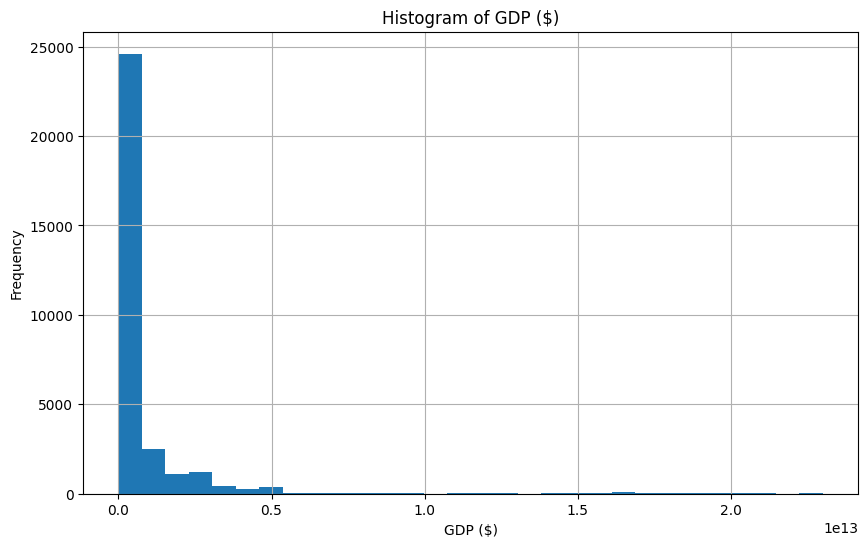

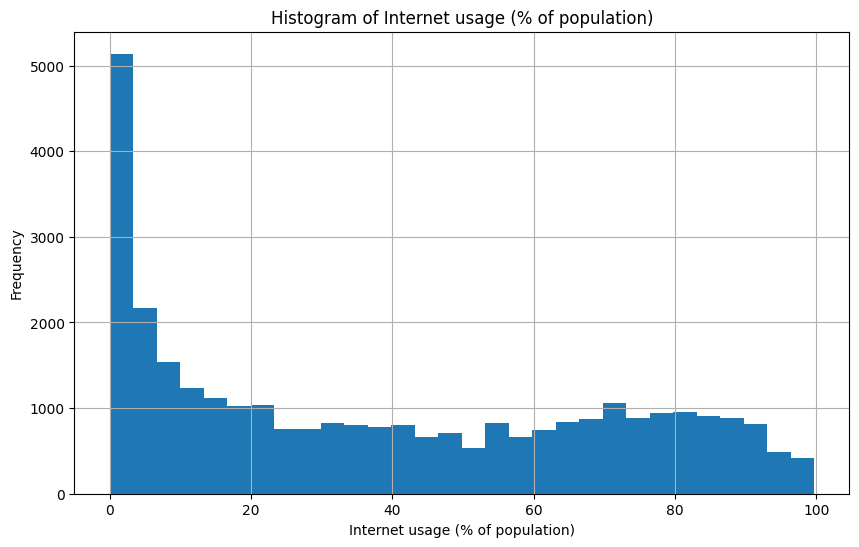

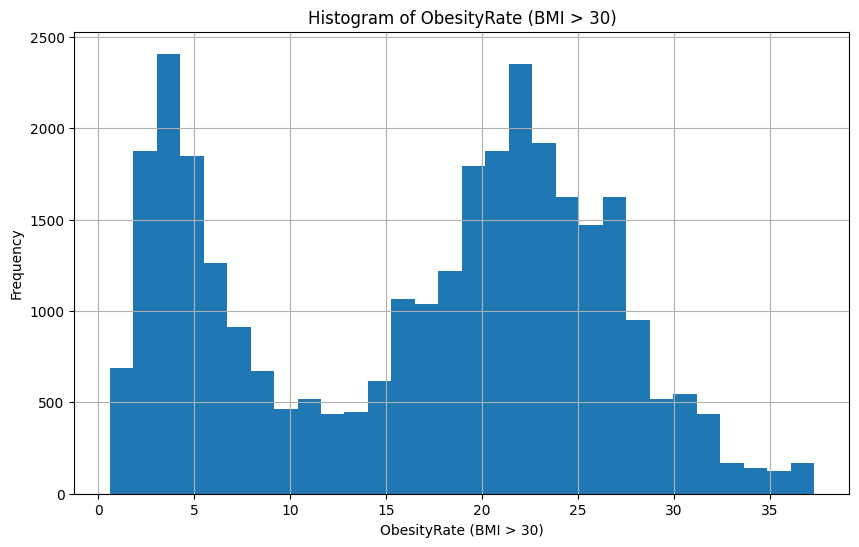

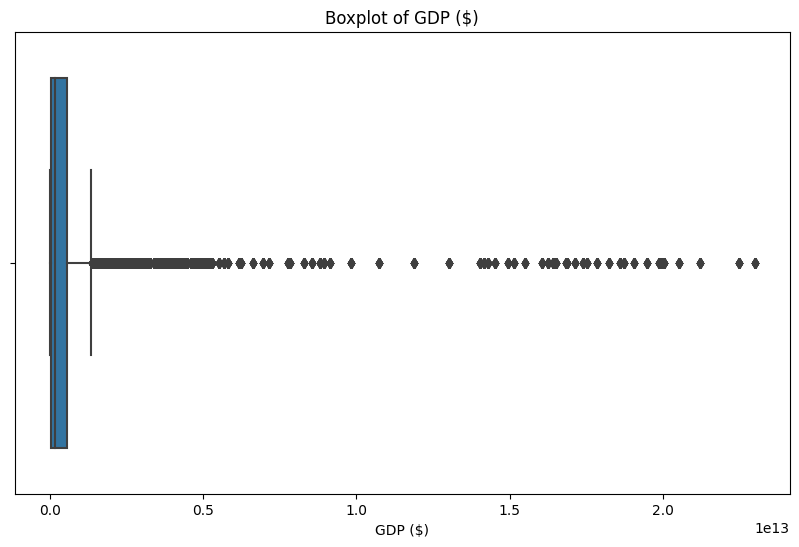

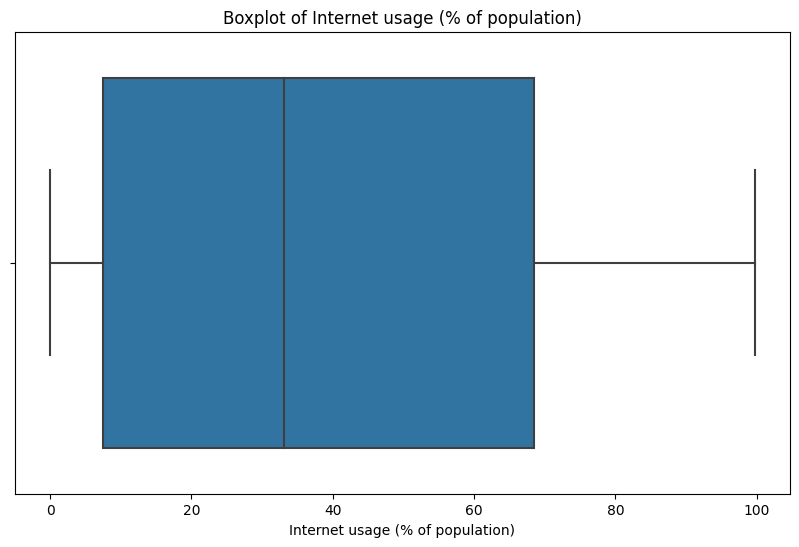

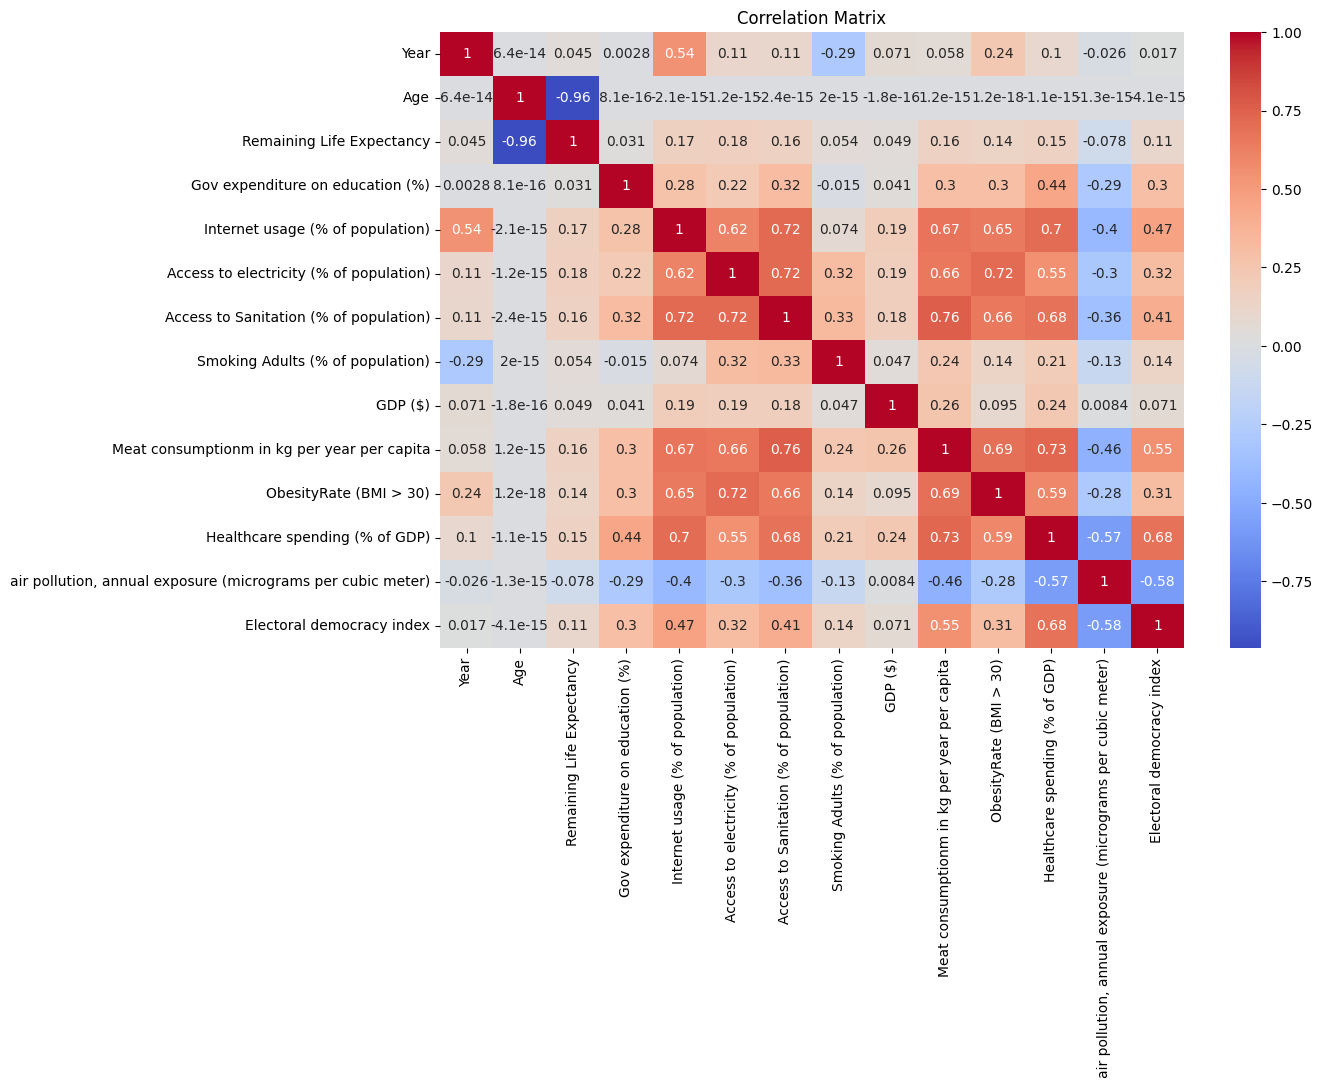

In [90]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
 
# Load the final merged dataset
final_df = pd.read_csv('final_merged_data.csv')
 
# Display basic descriptive statistics
print("Descriptive Statistics:")
print(final_df.describe())
 
# Histograms for selected columns
columns_to_visualize = ['GDP ($)', 'Internet usage (% of population)', 'ObesityRate (BMI > 30)']
for column in columns_to_visualize:
    plt.figure(figsize=(10, 6))
    final_df[column].hist(bins=30)
    plt.title(f'Histogram of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.show()
 
# Boxplots for potential outlier detection in specific columns
columns_for_outliers = ['GDP ($)', 'Internet usage (% of population)']
for column in columns_for_outliers:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=final_df[column])
    plt.title(f'Boxplot of {column}')
    plt.show()
 
# Correlation matrix (optional)
plt.figure(figsize=(12, 8))
# Update here: specify numeric_only=True
sns.heatmap(final_df.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# Feature Selection & Engineering

Korrelationen und welches sind wichtige features
binary encoding for categorial variables

In [91]:
# List of countries to be removed
countries_to_remove = [
    'United Arab Emirates', 'Cayman Islands', 'Suriname', 'Curacao', 'Turkmenistan',
    'South Sudan', 'Uzbekistan', 'Palestine', 'East Timor', 'Liberia', 'Vietnam', 'Nauru',
    'Serbia', 'American Samoa', 'Bahrain', 'Kosovo', 'Curacao', 'South Sudan', 'North Korea',
    'Liberia', 'South Sudan', 'Turks and Caicos Islands', 'Greenland', 'Channel Islands',
    'Montenegro', 'Djibouti', 'Somalia', 'Turks and Caicos Islands', 'Sint Maarten (Dutch part)',
    'Kosovo', 'Cayman Islands', 'Bahrain', 'Bhutan', 'Micronesia (country)', 'Nauru', 'Qatar',
    'South Sudan', 'Burundi', 'Sudan', 'Comoros', 'Democratic Republic of Congo', 'Libya',
    'Papua New Guinea', 'Seychelles', 'Syria', 'Montenegro', 'Serbia', 'South Sudan',
    'Montenegro', 'Zimbabwe'
]

# Remove rows with the specified countries
final_df = final_df[~final_df['Entity'].isin(countries_to_remove)]

final_df


,Entity,Code,Year,Sex,Age,Remaining Life Expectancy,Gov expenditure on education (%),Internet usage (% of population),Access to electricity (% of population),Access to Sanitation (% of population),Smoking Adults (% of population),GDP ($),Meat consumptionm in kg per year per capita,ObesityRate (BMI > 30),Healthcare spending (% of GDP),"air pollution, annual exposure (micrograms per cubic meter)",Electoral democracy index
0,Algeria,DZA,2000,Female,0,71.9487,4.982849,0.491706,98.97310,58.85,22.200000,2.703917e+11,18.933718,15.0,2.510828,37.536050,0.326
1,Algeria,DZA,2001,Female,0,72.1968,4.902120,0.646114,98.96687,59.19,22.120000,2.785034e+11,17.341906,15.5,2.925499,37.200605,0.326
2,Algeria,DZA,2002,Female,0,72.5595,4.821391,1.591641,98.95306,59.53,22.040000,2.940996e+11,18.096855,16.1,2.807926,36.865160,0.329
3,Algeria,DZA,2003,Female,0,72.2499,4.740663,2.195360,98.93401,59.86,21.960000,3.152748e+11,19.324575,16.7,2.761790,36.529716,0.335
4,Algeria,DZA,2004,Female,0,72.8122,4.659934,4.634475,98.91208,60.18,21.880000,3.288316e+11,21.336285,17.3,2.528820,36.194271,0.336
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31096,United States,USA,2016,Male,80,8.7799,4.806660,85.544420,100.00000,97.19,24.666667,1.905248e+13,118.195300,37.3,8.557327,7.406464,0.884
31097,United States,USA,2017,Male,80,8.7725,5.122880,87.274890,100.00000,97.16,24.033333,1.947962e+13,119.273290,37.3,8.512190,7.409441,0.820
31098,United States,USA,2018,Male,80,8.8969,4.928890,88.498900,100.00000,97.14,23.400000,2.005337e+13,123.623640,37.3,8.472342,7.409441,0.813
31099,United States,USA,2019,Male,80,9.0346,4.987280,89.430280,100.00000,97.11,23.400000,2.051348e+13,126.303100,37.3,8.524923,7.409441,0.800


#### Binary encoding

In [92]:

final_df2 = final_df.drop('Code', axis=1)
 
# Selected columns for binary encoding
columns_to_encode = ['Sex', 'Entity']
 
# Create a new DataFrame for training with binary encoding
encoder = ce.BinaryEncoder(cols=columns_to_encode, drop_invariant=True, return_df=True)

training_dataset = encoder.fit_transform(final_df2)
 
# Save the original column names before encoding
original_columns = encoder.get_feature_names_out()
 
# Save the result

training_dataset.to_csv('training_dataset_binary.csv', index=False)
 
# Back-encode to get the original DataFrame
original_df = encoder.inverse_transform(training_dataset[original_columns])
 
training_dataset

,Entity_0,Entity_1,Entity_2,Entity_3,Entity_4,Entity_5,Entity_6,Year,Sex_0,Sex_1,...,Internet usage (% of population),Access to electricity (% of population),Access to Sanitation (% of population),Smoking Adults (% of population),GDP ($),Meat consumptionm in kg per year per capita,ObesityRate (BMI > 30),Healthcare spending (% of GDP),"air pollution, annual exposure (micrograms per cubic meter)",Electoral democracy index
0,0,0,0,0,0,0,1,2000,0,1,...,0.491706,98.97310,58.85,22.200000,2.703917e+11,18.933718,15.0,2.510828,37.536050,0.326
1,0,0,0,0,0,0,1,2001,0,1,...,0.646114,98.96687,59.19,22.120000,2.785034e+11,17.341906,15.5,2.925499,37.200605,0.326
2,0,0,0,0,0,0,1,2002,0,1,...,1.591641,98.95306,59.53,22.040000,2.940996e+11,18.096855,16.1,2.807926,36.865160,0.329
3,0,0,0,0,0,0,1,2003,0,1,...,2.195360,98.93401,59.86,21.960000,3.152748e+11,19.324575,16.7,2.761790,36.529716,0.335
4,0,0,0,0,0,0,1,2004,0,1,...,4.634475,98.91208,60.18,21.880000,3.288316e+11,21.336285,17.3,2.528820,36.194271,0.336
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31096,1,1,0,0,0,1,1,2016,1,0,...,85.544420,100.00000,97.19,24.666667,1.905248e+13,118.195300,37.3,8.557327,7.406464,0.884
31097,1,1,0,0,0,1,1,2017,1,0,...,87.274890,100.00000,97.16,24.033333,1.947962e+13,119.273290,37.3,8.512190,7.409441,0.820
31098,1,1,0,0,0,1,1,2018,1,0,...,88.498900,100.00000,97.14,23.400000,2.005337e+13,123.623640,37.3,8.472342,7.409441,0.813
31099,1,1,0,0,0,1,1,2019,1,0,...,89.430280,100.00000,97.11,23.400000,2.051348e+13,126.303100,37.3,8.524923,7.409441,0.800


#### onehot encoding

In [93]:
final_df2 = final_df.drop('Code', axis=1)

# Selected columns for one-hot encoding
columns_to_encode = ['Sex', 'Entity']

# Create a new DataFrame for training with one-hot encoding
encoder = ce.OneHotEncoder(cols=columns_to_encode, use_cat_names=True)

training_dataset_onehot = encoder.fit_transform(final_df2)

# Save the result as CSV
training_dataset_onehot.to_csv('training_dataset_onehot.csv', index=False)

training_dataset_onehot

,Entity_Algeria,Entity_Argentina,Entity_Armenia,Entity_Australia,Entity_Austria,Entity_Azerbaijan,Entity_Bangladesh,Entity_Belarus,Entity_Belgium,Entity_Benin,...,Internet usage (% of population),Access to electricity (% of population),Access to Sanitation (% of population),Smoking Adults (% of population),GDP ($),Meat consumptionm in kg per year per capita,ObesityRate (BMI > 30),Healthcare spending (% of GDP),"air pollution, annual exposure (micrograms per cubic meter)",Electoral democracy index
0,1,0,0,0,0,0,0,0,0,0,...,0.491706,98.97310,58.85,22.200000,2.703917e+11,18.933718,15.0,2.510828,37.536050,0.326
1,1,0,0,0,0,0,0,0,0,0,...,0.646114,98.96687,59.19,22.120000,2.785034e+11,17.341906,15.5,2.925499,37.200605,0.326
2,1,0,0,0,0,0,0,0,0,0,...,1.591641,98.95306,59.53,22.040000,2.940996e+11,18.096855,16.1,2.807926,36.865160,0.329
3,1,0,0,0,0,0,0,0,0,0,...,2.195360,98.93401,59.86,21.960000,3.152748e+11,19.324575,16.7,2.761790,36.529716,0.335
4,1,0,0,0,0,0,0,0,0,0,...,4.634475,98.91208,60.18,21.880000,3.288316e+11,21.336285,17.3,2.528820,36.194271,0.336
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31096,0,0,0,0,0,0,0,0,0,0,...,85.544420,100.00000,97.19,24.666667,1.905248e+13,118.195300,37.3,8.557327,7.406464,0.884
31097,0,0,0,0,0,0,0,0,0,0,...,87.274890,100.00000,97.16,24.033333,1.947962e+13,119.273290,37.3,8.512190,7.409441,0.820
31098,0,0,0,0,0,0,0,0,0,0,...,88.498900,100.00000,97.14,23.400000,2.005337e+13,123.623640,37.3,8.472342,7.409441,0.813
31099,0,0,0,0,0,0,0,0,0,0,...,89.430280,100.00000,97.11,23.400000,2.051348e+13,126.303100,37.3,8.524923,7.409441,0.800


### List the encodings

In [94]:
# Extract binary encoded 'Entity' columns
binary_encoded_entities = training_dataset.filter(regex='^Entity_')

# Retrieve the original 'Entity' values from the back-encoded DataFrame
original_entities = original_df['Entity']

# Create a DataFrame that pairs each original 'Entity' with its binary encoding
entity_binary_encoding = pd.concat([original_entities, binary_encoded_entities], axis=1).drop_duplicates()

# Convert the DataFrame to a list of tuples for easier reading
entity_binary_encoding_list = list(entity_binary_encoding.itertuples(index=False, name=None))

# Print the list to see the original 'Entity' and their binary encodings
for item in entity_binary_encoding_list:
    print(item)




('Algeria', 0, 0, 0, 0, 0, 0, 1)
('Argentina', 0, 0, 0, 0, 0, 1, 0)
('Armenia', 0, 0, 0, 0, 0, 1, 1)
('Australia', 0, 0, 0, 0, 1, 0, 0)
('Austria', 0, 0, 0, 0, 1, 0, 1)
('Azerbaijan', 0, 0, 0, 0, 1, 1, 0)
('Bangladesh', 0, 0, 0, 0, 1, 1, 1)
('Belarus', 0, 0, 0, 1, 0, 0, 0)
('Belgium', 0, 0, 0, 1, 0, 0, 1)
('Benin', 0, 0, 0, 1, 0, 1, 0)
('Brazil', 0, 0, 0, 1, 0, 1, 1)
('Bulgaria', 0, 0, 0, 1, 1, 0, 0)
('Burkina Faso', 0, 0, 0, 1, 1, 0, 1)
('Cambodia', 0, 0, 0, 1, 1, 1, 0)
('Canada', 0, 0, 0, 1, 1, 1, 1)
('Chad', 0, 0, 1, 0, 0, 0, 0)
('Chile', 0, 0, 1, 0, 0, 0, 1)
('China', 0, 0, 1, 0, 0, 1, 0)
('Colombia', 0, 0, 1, 0, 0, 1, 1)
('Costa Rica', 0, 0, 1, 0, 1, 0, 0)
("Cote d'Ivoire", 0, 0, 1, 0, 1, 0, 1)
('Croatia', 0, 0, 1, 0, 1, 1, 0)
('Cyprus', 0, 0, 1, 0, 1, 1, 1)
('Czechia', 0, 0, 1, 1, 0, 0, 0)
('Denmark', 0, 0, 1, 1, 0, 0, 1)
('Dominican Republic', 0, 0, 1, 1, 0, 1, 0)
('Ecuador', 0, 0, 1, 1, 0, 1, 1)
('Egypt', 0, 0, 1, 1, 1, 0, 0)
('Estonia', 0, 0, 1, 1, 1, 0, 1)
('Ethiopia', 0, 0, 

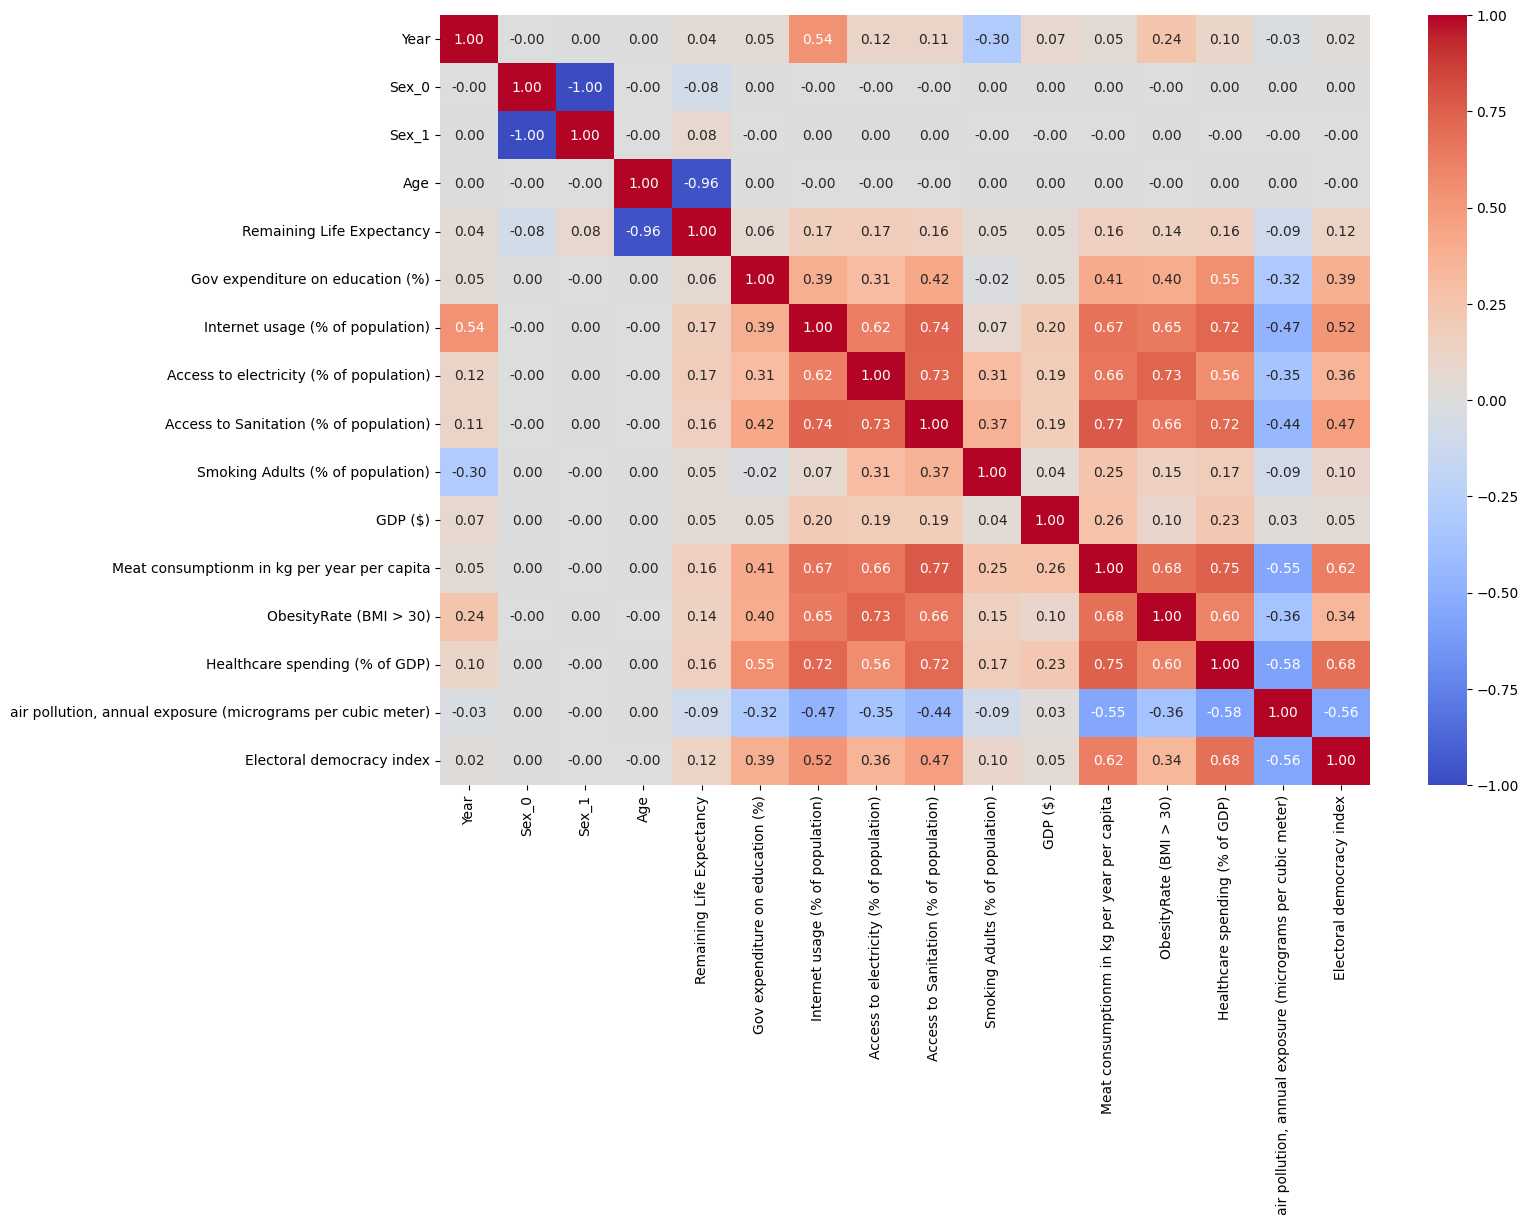

In [95]:
# Exclude columns 'Entity_0' to 'Entity_6' from the correlation matrix
columns_to_exclude = [f'Entity_{i}' for i in range(7)]  # Assuming you have 'Entity_0' to 'Entity_6'
correlation_matrix = training_dataset.drop(columns=columns_to_exclude).corr()

# Set up the matplotlib figure
plt.figure(figsize=(15, 10))

# Create a heatmap using seaborn
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")

# Show the plot
plt.show()
#    0 to 0.2: Very weak correlation
#    0.2 to 0.4: Weak correlation
#    0.4 to 0.6: Moderate correlation
#    0.6 to 0.8: Strong correlation
#    0.8 to 1.0: Very strong correlation

# Anwendung in Machine Learning

##### Linear regression

In [96]:
data = pd.read_csv('training_dataset_binary.csv')

#Remaining Life Expectancy target variable
X = data.drop('Remaining Life Expectancy', axis=1)
y = data['Remaining Life Expectancy']

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predicting and evaluating the model
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f"Model Performance: RMSE = {rmse}")

# Save model
dump(model, 'frontend/linreg.joblib')

Model Performance: RMSE = 3.7843046284528907


['frontend/linreg.joblib']

#### Random Forest 

In [97]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
 
# Laden der Daten
data = pd.read_csv('training_dataset_binary.csv')
 
# Zielvariable ist "Remaining Life Expectancy"
X = data.drop('Remaining Life Expectancy', axis=1)
y = data['Remaining Life Expectancy']
 
# Aufteilung der Daten in Trainings- und Testsets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
 
# Initialisierung und Training des Random Forest Regressors
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)
 
# Vorhersagen und Auswertung des Modells
y_pred = rf_model.predict(X_test)
 
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
 
print(f"Model Performance:")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared (R2): {r2}")
 
 
# Feature Importance
feature_importance = rf_model.feature_importances_
 
# Verknüpfen der Feature-Wichtigkeiten mit den entsprechenden Feature-Namen
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
 
# Ausgabe der wichtigsten Features
print("Feature Importance:")
print(feature_importance_df.round(5))

Model Performance:
Mean Squared Error (MSE): 0.44729324358144995
Root Mean Squared Error (RMSE): 0.6687998531559722
Mean Absolute Error (MAE): 0.402413476296806
R-squared (R2): 0.9992023186046252
Feature Importance:
                                              Feature  Importance
10                                                Age     0.93227
13            Access to electricity (% of population)     0.03924
21                          Electoral democracy index     0.00525
8                                               Sex_0     0.00439
9                                               Sex_1     0.00410
19                     Healthcare spending (% of GDP)     0.00307
15                   Smoking Adults (% of population)     0.00185
12                   Internet usage (% of population)     0.00160
16                                            GDP ($)     0.00147
14             Access to Sanitation (% of population)     0.00143
18                             ObesityRate (BMI > 30)     

#### XGBoost

In [98]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
 
# Load the binary-encoded dataset
data_binary = pd.read_csv('training_dataset_binary.csv')
 
# Separate the features and the target variable
X_binary = data_binary.drop('Remaining Life Expectancy', axis=1)
y_binary = data_binary['Remaining Life Expectancy']
 
# Split the dataset into training and test sets
X_train_binary, X_test_binary, y_train_binary, y_test_binary = train_test_split(X_binary, y_binary, test_size=0.2, random_state=42)
 
# Initialize the XGBoost regressor
model_binary = xgb.XGBRegressor(objective='reg:squarederror')
 
# Train the model
model_binary.fit(X_train_binary, y_train_binary)
 
# Predict and evaluate the model
predictions_binary = model_binary.predict(X_test_binary)
mse_binary = mean_squared_error(y_test_binary, predictions_binary)
 
# Calculate RMSE
rmse_binary = np.sqrt(mse_binary)
print(f'Root Mean Squared Error for binary-encoded dataset: {rmse_binary}')

Root Mean Squared Error for binary-encoded dataset: 0.6732615972719469


In [108]:
# Load the one-hot-encoded dataset
data_onehot = pd.read_csv('training_dataset_onehot.csv')
 
# Separate the features and the target variable
X_onehot = data_onehot.drop('Remaining Life Expectancy', axis=1)
y_onehot = data_onehot['Remaining Life Expectancy']
 
# Split the dataset into training and test sets
X_train_onehot, X_test_onehot, y_train_onehot, y_test_onehot = train_test_split(X_onehot, y_onehot, test_size=0.2, random_state=42)
 
# Initialize the XGBoost regressor
model_onehot = xgb.XGBRegressor(objective='reg:squarederror')

# Train the model
model_onehot.fit(X_train_onehot, y_train_onehot)

# Predictions on the test set
predictions_test = model_onehot.predict(X_test_onehot)
mse_test = mean_squared_error(y_test_onehot, predictions_test)
rmse_test = np.sqrt(mse_test)

# Predictions on the training set
predictions_train = model_onehot.predict(X_train_onehot)
mse_train = mean_squared_error(y_train_onehot, predictions_train)
rmse_train = np.sqrt(mse_train)

# Output the RMSE for both sets
print(f'Root Mean Squared Error for Training Set: {rmse_train}')
print(f'Root Mean Squared Error for Test Set: {rmse_test}')



Root Mean Squared Error for Training Set: 0.5591864650547645
Root Mean Squared Error for Test Set: 0.6703531866809824


#### Feedforward Neural Network

In [141]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd

torch.manual_seed(42)

# Load the dataset
data = pd.read_csv('training_dataset_binary.csv')  

# Separate the features and the target variable
X = data.drop('Remaining Life Expectancy', axis=1).values
y = data['Remaining Life Expectancy'].values

# Standardize the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Further split X_train and y_train for validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)

# Create PyTorch datasets
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

# Data loaders
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

# Neural Network
class NeuralNet(nn.Module):
    def __init__(self, input_size):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, 256)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(256, 128)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(128, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        return x

# Model, Loss, and Optimizer
model = NeuralNet(X_train.shape[1])
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Early stopping parameters
patience = 20
best_loss = float('inf')
epochs_no_improve = 0

# Training the Model
num_epochs = 200
# Lists to store losses
train_losses = []
val_losses = []

# Modified Training Loop
for epoch in range(num_epochs):
    model.train()  # Training mode
    train_loss = 0
    for inputs, targets in train_loader:
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    model.eval()  # Evaluation mode
    val_loss = 0
    with torch.no_grad():
        for inputs, targets in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    avg_val_loss = val_loss / len(val_loader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Validation Loss: {avg_val_loss:.4f}')

    # Check for early stopping
    if avg_val_loss < best_loss:
        best_loss = avg_val_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    if epochs_no_improve == patience:
        print(f'Early stopping triggered after {epoch+1} epochs!')
        break

# Evaluate the model on test set
model.eval()  # Set the model to evaluation mode
test_loss = 0
with torch.no_grad():
    for inputs, targets in test_loader:
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), targets)
        test_loss += loss.item()

avg_test_loss = test_loss / len(test_loader)
print('Mean Absolute Error on test set:', avg_test_loss)


Epoch [1/200], Validation Loss: 12.1414
Epoch [2/200], Validation Loss: 5.2587
Epoch [3/200], Validation Loss: 3.3766
Epoch [4/200], Validation Loss: 2.6190
Epoch [5/200], Validation Loss: 2.0887
Epoch [6/200], Validation Loss: 1.7417
Epoch [7/200], Validation Loss: 1.4320
Epoch [8/200], Validation Loss: 1.2216
Epoch [9/200], Validation Loss: 1.1472
Epoch [10/200], Validation Loss: 0.9705
Epoch [11/200], Validation Loss: 1.0036
Epoch [12/200], Validation Loss: 0.8502
Epoch [13/200], Validation Loss: 0.8457
Epoch [14/200], Validation Loss: 0.7455
Epoch [15/200], Validation Loss: 0.8995
Epoch [16/200], Validation Loss: 0.6977
Epoch [17/200], Validation Loss: 0.7124
Epoch [18/200], Validation Loss: 0.8071
Epoch [19/200], Validation Loss: 0.6190
Epoch [20/200], Validation Loss: 0.6089
Epoch [21/200], Validation Loss: 0.5243
Epoch [22/200], Validation Loss: 0.4862
Epoch [23/200], Validation Loss: 0.4680
Epoch [24/200], Validation Loss: 0.5479
Epoch [25/200], Validation Loss: 0.4985
Epoch [2

In [142]:
import math

# Calculate RMSE
rmse = math.sqrt(avg_test_loss)
print('Root Mean Square Error on test set:', rmse)


Root Mean Square Error on test set: 0.39105416229337425


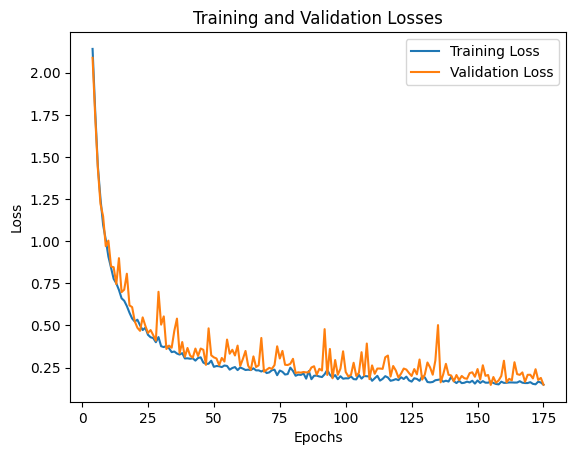

In [144]:
import joblib

# Start plotting from epoch 5 (index 4), assuming train_losses and val_losses are complete
plt.plot(range(4, len(train_losses)), train_losses[4:], label='Training Loss')
plt.plot(range(4, len(val_losses)), val_losses[4:], label='Validation Loss')
plt.title('Training and Validation Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Save the scaler
joblib.dump(scaler, 'frontend/scaler.save')

#save model
torch.save(model.state_dict(), 'frontend/FNN_model.pth')

##### Linear regression SGD (Binary)

In [101]:
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler

# Load the dataset (binary encoding)
data_binary = pd.read_csv('training_dataset_binary.csv')

# Splitting the data into features and target variable
X_binary = data_onehot.drop('Remaining Life Expectancy', axis=1)
y_binary = data_onehot['Remaining Life Expectancy']

# Splitting the data into training and testing sets
X_train_binary, X_test_binary, y_train_binary, y_test_binary = train_test_split(X_binary, y_binary, test_size=0.2, random_state=42)

# Standardizing the features
scaler_binary = StandardScaler()
X_train_scaled_binary = scaler_binary.fit_transform(X_train_binary)
X_test_scaled_binary = scaler_binary.transform(X_test_binary)

# Creating and training the SGD Regressor
sgd_reg_binary = SGDRegressor(random_state=42)
sgd_reg_binary.fit(X_train_scaled_binary, y_train_binary)

# Predictions
y_pred_sgd_binary = sgd_reg_binary.predict(X_test_scaled_binary)

# Evaluation
mse_sgd_binary = mean_squared_error(y_test_binary, y_pred_sgd_binary)
rmse_sgd_binary = np.sqrt(mse_sgd_binary)

print(f"SGD Regressor Performance on Binary Encoded Data: RMSE = {rmse_sgd_binary}")

# Save the SGD model (binary encoding)
dump(sgd_reg_binary, 'frontend/sgd_reg_binary.joblib')

SGD Regressor Performance on Binary Encoded Data: RMSE = 3.2676450728971567


['frontend/sgd_reg_binary.joblib']

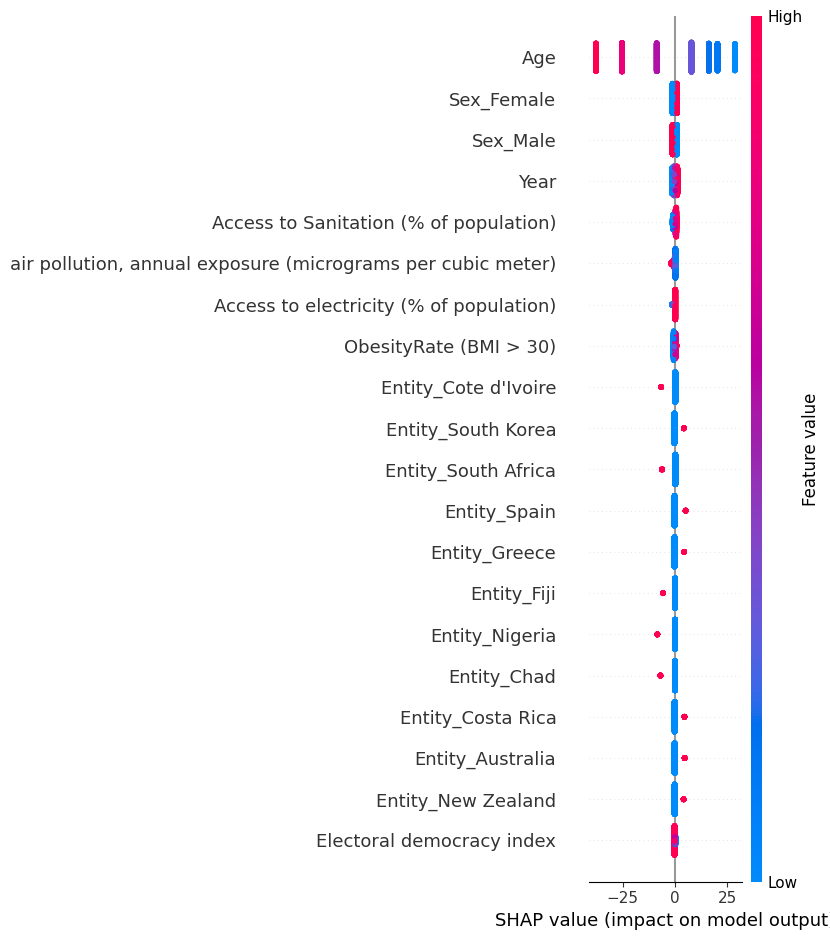

In [102]:
import shap

# Erstellen eines SHAP-Explainers für das Modell
explainer_binary = shap.Explainer(sgd_reg_binary, X_train_scaled_binary)

# Berechnung der SHAP-Werte für die Testdaten
shap_values_binary = explainer_binary(X_test_scaled_binary)

# Visualisierung der SHAP-Werte (zum Beispiel mit einem Summary Plot)
shap.summary_plot(shap_values_binary, X_test_scaled_binary, feature_names=X_binary.columns)

##### Linear regression SGD (One Hot)

In [103]:
# Load the dataset (one-hot encoding)
data_onehot = pd.read_csv('training_dataset_onehot.csv')

# Splitting the data into features and target variable
X_onehot = data_onehot.drop('Remaining Life Expectancy', axis=1)
y_onehot = data_onehot['Remaining Life Expectancy']

# Splitting the data into training and testing sets
X_train_onehot, X_test_onehot, y_train_onehot, y_test_onehot = train_test_split(X_onehot, y_onehot, test_size=0.2, random_state=42)

# Standardizing the features
scaler_onehot = StandardScaler()
X_train_scaled_onehot = scaler_onehot.fit_transform(X_train_onehot)
X_test_scaled_onehot = scaler_onehot.transform(X_test_onehot)

# Creating and training the SGD Regressor
sgd_reg_onehot = SGDRegressor(random_state=42)
sgd_reg_onehot.fit(X_train_scaled_onehot, y_train_onehot)

# Predictions
y_pred_sgd_onehot = sgd_reg_onehot.predict(X_test_scaled_onehot)

# Evaluation
mse_sgd_onehot = mean_squared_error(y_test_onehot, y_pred_sgd_onehot)
rmse_sgd_onehot = np.sqrt(mse_sgd_onehot)

print(f"SGD Regressor Performance on One-Hot Encoded Data: RMSE = {rmse_sgd_onehot}")

# Save the SGD model (one-hot encoding)
dump(sgd_reg_onehot, 'frontend/sgd_reg_onehot.joblib')


SGD Regressor Performance on One-Hot Encoded Data: RMSE = 3.2676450728971567


['frontend/sgd_reg_onehot.joblib']

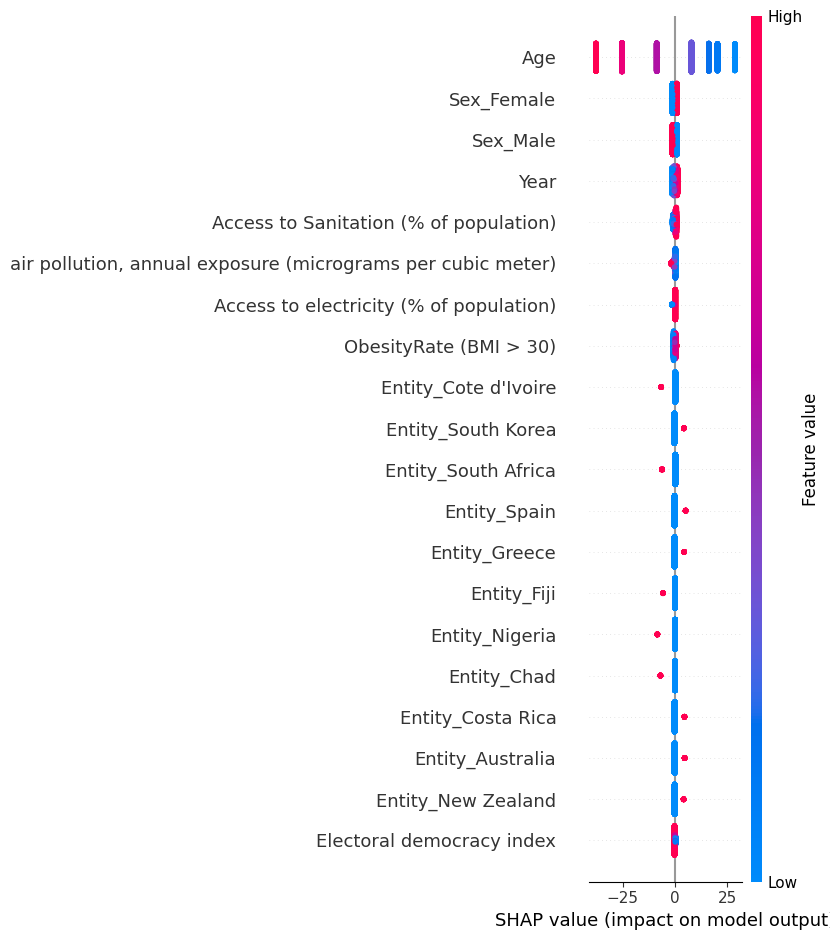

In [105]:
# Erstellen eines SHAP-Explainers für das Modell
explainer_onehot = shap.Explainer(sgd_reg_onehot, X_train_scaled_onehot)

# Berechnung der SHAP-Werte für die Testdaten
shap_values_onehot = explainer_onehot(X_test_scaled_onehot)

# Visualisierung der SHAP-Werte (zum Beispiel mit einem Summary Plot)
shap.summary_plot(shap_values_onehot, X_test_scaled_onehot, feature_names=X_onehot.columns)

#### Cross Validation

In [106]:
array = df.values
X = array[:,1:30]
Y = array[:,0]
# prepare configuration for cross validation test harness
seed = 7
# prepare models
models = []
models.append(('LR', LogisticRegression(max_iter=1000, solver='liblinear')))
models.append(('NB', GaussianNB()))
models.append(('CART', DecisionTreeClassifier(max_depth=9)))
models.append(('KNN', KNeighborsClassifier(n_neighbors=15)))
models.append(('RF', RandomForestClassifier(max_depth = 3, max_leaf_nodes = 3, n_estimators = 3, random_state = 42)))
models.append(('SVM', svm.SVC()))
models.append(('NN', MLPClassifier(hidden_layer_sizes = 17, activation = 'relu', random_state = 42)))
models.append(('XGB', XGBClassifier(random_state=42,gpu_id=0)))
# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
for name, model in models:
    kfold = model_selection.KFold(n_splits=10, random_state=seed, shuffle=True)
    cv_results = model_selection.cross_val_score(model, X, Y, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

NameError: name 'LogisticRegression' is not defined

# Anwendung von XAI – Techniken

In [ ]:
coefficients = pd.DataFrame(model.coef_, X.columns, columns=['Coefficient'])
print(coefficients)

AttributeError: 'NeuralNet' object has no attribute 'coef_'

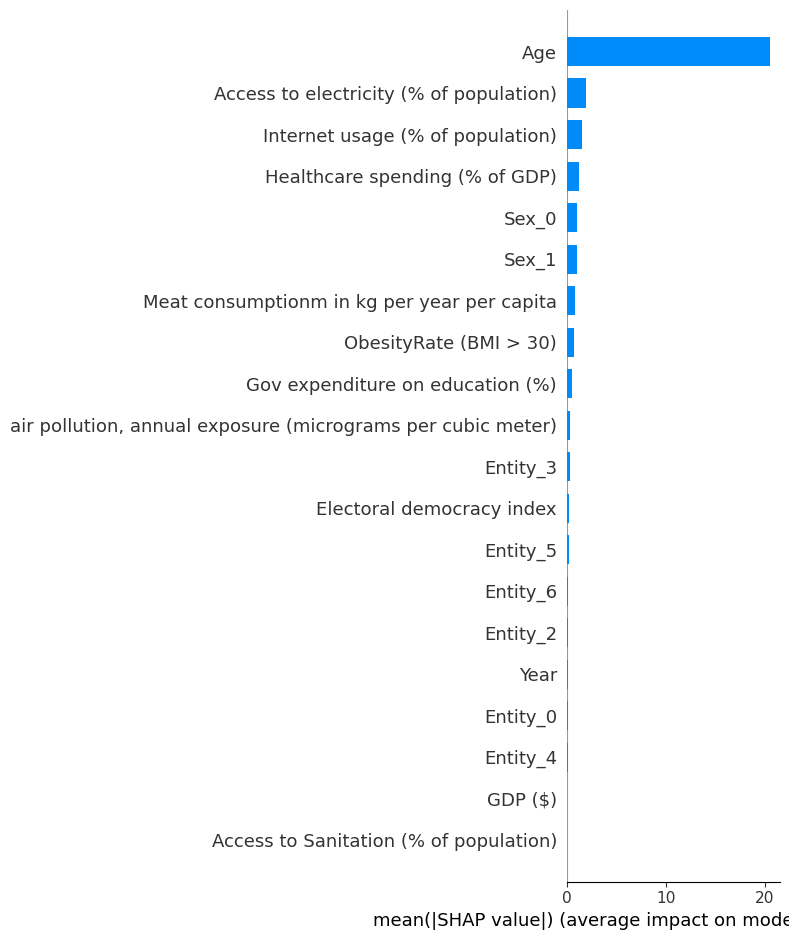

In [ ]:
import shap
 
# SHAP-Werte berechnen
explainer = shap.LinearExplainer(model, X_train)
shap_values = explainer.shap_values(X_test)
 
# SHAP-Zusammenfassungsplot
shap.summary_plot(shap_values, X_test, plot_type="bar")
 
# SHAP-Werte für einen spezifischen Datenpunkt
shap.initjs()
i = 20  # Index des Datenpunkts
shap.force_plot(explainer.expected_value, shap_values[i], X_test.iloc[i])

# Applikation